In [ ]:
# train_model_optimized.py
import os
import numpy as np # type: ignore
import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
from torch.utils.data import Dataset, DataLoader # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # type: ignore
from tqdm import tqdm # type: ignore
import random

# ---------------- CONFIG ----------------
DATA_DIR = r"processed_lstm_inputs"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 4
EPOCHS = 40
LR = 1e-3
VAL_SPLIT = 0.2
PATIENCE = 7               # early stopping patience (on val F1)
PER_ELEC_CHANNELS = 8
SPATIAL_OUT = 32
LSTM_HIDDEN = 64
DROPOUT = 0.3
GRAD_CLIP = 1.0            # gradient clipping
NUM_WORKERS = 0            # Windows: keep 0; change if on Linux and you want speed

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ---------------- Dataset (lazy per-file load) ----------------
class EEGFileDataset(Dataset):
    """
    Each item is one .npy file shaped (segments=44, time_windows=8, H=5, W=5, features=200)
    Label 0=healthy,1=patient
    """
    def __init__(self, data_dir, folders=("healthy","patient")):
        self.files = []
        self.labels = []
        for label, folder in enumerate(folders):
            folder_path = os.path.join(data_dir, folder)
            if not os.path.isdir(folder_path):
                raise FileNotFoundError(f"{folder_path} not found")
            for fname in os.listdir(folder_path):
                if fname.endswith(".npy"):
                    self.files.append(os.path.join(folder_path, fname))
                    self.labels.append(label)
        if len(self.files) == 0:
            raise RuntimeError("No .npy files found.")
        # deterministic order
        idxs = np.argsort(self.files)
        self.files = [self.files[i] for i in idxs]
        self.labels = np.array([self.labels[i] for i in idxs], dtype=np.int64)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        arr = np.load(self.files[idx])   # expected (44,8,5,5,200)
        if arr.ndim != 5:
            raise ValueError(f"{self.files[idx]} shape {arr.shape} != (44,8,5,5,200)")
        arr = arr.astype(np.float32)
        # per-file normalization (global)
        arr = (arr - arr.mean()) / (arr.std() + 1e-6)
        return torch.from_numpy(arr), torch.tensor(self.labels[idx], dtype=torch.long)

# ---------------- Model ----------------
class FullEEGModel(nn.Module):
    def __init__(self, per_elec_channels=PER_ELEC_CHANNELS, spatial_out=SPATIAL_OUT,
                 lstm_hidden=LSTM_HIDDEN, dropout=DROPOUT):
        super().__init__()
        # per-electrode temporal conv
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(1, per_elec_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(per_elec_channels, per_elec_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        # per-segment spatial conv (C, H, W) -> spatial_out
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(per_elec_channels, per_elec_channels*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(per_elec_channels*2, spatial_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        # global spatial branch
        self.global_spatial_conv = nn.Sequential(
            nn.Conv2d(per_elec_channels, per_elec_channels*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        # LSTM over segments (44)
        self.lstm = nn.LSTM(input_size=spatial_out, hidden_size=lstm_hidden, batch_first=True)
        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden + (per_elec_channels*2), 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x: (B, S=44, T=8, H=5, W=5, F=200)
        B, S, T, H, W, F = x.shape
        # apply 1D conv per electrode: reshape to (B*S*T*H*W, 1, F)
        x_flat = x.view(B*S*T*H*W, F).unsqueeze(1)
        tc = self.temporal_conv(x_flat).squeeze(-1)   # (N, per_elec_channels)
        C = tc.shape[1]
        tc = tc.view(B, S, T, C, H, W)                # (B, S, T, C, H, W)
        # collapse T (intra-segment windows) by mean -> (B, S, C, H, W)
        per_segment_map = tc.mean(dim=2)
        # spatial conv per-segment
        segs = per_segment_map.view(B*S, C, H, W)
        sp = self.spatial_conv(segs).view(B, S, -1)   # (B, S, spatial_out)
        # LSTM across segments
        lstm_out, _ = self.lstm(sp)                   # (B, S, lstm_hidden)
        lstm_last = lstm_out[:, -1, :]
        # global spatial map (avg across segments) -> conv
        global_map = per_segment_map.mean(dim=1)      # (B, C, H, W)
        gsp = self.global_spatial_conv(global_map).view(B, -1)  # (B, C2)
        # concat and classify
        cat = torch.cat([lstm_last, gsp], dim=1)
        logits = self.classifier(cat).squeeze(1)
        return logits

# ---------------- Helpers ----------------
def prepare_loaders(data_dir, batch_size=BATCH_SIZE, val_split=VAL_SPLIT, seed=SEED):
    ds = EEGFileDataset(data_dir)
    indices = np.arange(len(ds))
    labels = np.array([ds[i][1].item() for i in range(len(ds))])
    train_idx, val_idx = train_test_split(indices, test_size=val_split, stratify=labels, random_state=seed)
    train_ds = torch.utils.data.Subset(ds, train_idx)
    val_ds = torch.utils.data.Subset(ds, val_idx)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
    # compute pos_weight using training labels only
    train_labels = labels[train_idx]
    neg = (train_labels == 0).sum()
    pos = (train_labels == 1).sum()
    pos_weight = torch.tensor([neg / (pos + 1e-12)], dtype=torch.float32).to(DEVICE)
    print(f"Files total={len(ds)} train={len(train_ds)} val={len(val_ds)} | train healthy={neg} patient={pos} pos_weight={pos_weight.item():.3f}")
    return train_loader, val_loader, pos_weight

# ---------------- Train & Eval ----------------
def train_and_evaluate():
    train_loader, val_loader, pos_weight = prepare_loaders(DATA_DIR)
    model = FullEEGModel().to(DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    best_val_f1 = 0.0
    no_improve = 0

    for epoch in range(1, EPOCHS+1):
        model.train()
        train_losses = []
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - train"):
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE).float()
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            train_losses.append(loss.item())

        # validation
        model.eval()
        val_losses = []
        preds, trues = [], []
        with torch.no_grad():
            for Xv, yv in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} - val"):
                Xv = Xv.to(DEVICE)
                yv = yv.to(DEVICE).float()
                logits = model(Xv)
                loss = criterion(logits, yv)
                val_losses.append(loss.item())
                probs = torch.sigmoid(logits).cpu().numpy()
                preds.extend((probs >= 0.5).astype(int).tolist())
                trues.extend(yv.cpu().numpy().astype(int).tolist())

        avg_train = float(np.mean(train_losses)) if train_losses else 0.0
        avg_val = float(np.mean(val_losses)) if val_losses else 0.0
        acc = accuracy_score(trues, preds) if len(trues)>0 else 0.0
        prec = precision_score(trues, preds, zero_division=0)
        rec = recall_score(trues, preds, zero_division=0)
        f1 = f1_score(trues, preds, zero_division=0)
        print(f"[{epoch}/{EPOCHS}] TrainLoss={avg_train:.4f} ValLoss={avg_val:.4f} | Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f}")

        scheduler.step(avg_val)

        for param_group in optimizer.param_groups:
            print(f"Current Learning Rate: {param_group['lr']:.6f}")

        # early stopping on val F1
        if f1 > best_val_f1 + 1e-4:
            best_val_f1 = f1
            no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")
            print(f"  Saved best model (val F1={best_val_f1:.4f})")
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print("Early stopping triggered.")
                break

    # final evaluation
    if os.path.exists("best_model.pth"):
        model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
        print("\nLoaded best_model.pth for final evaluation.")
    else:
        print("\nNo saved best model; evaluating last model state.")

    all_preds, all_trues = [], []
    model.eval()
    with torch.no_grad():
        for Xv, yv in tqdm(val_loader, desc="Final evaluation"):
            Xv = Xv.to(DEVICE)
            yv = yv.to(DEVICE)
            logits = model(Xv)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend((probs >= 0.5).astype(int).tolist())
            all_trues.extend(yv.cpu().numpy().astype(int).tolist())

    acc = accuracy_score(all_trues, all_preds)
    prec = precision_score(all_trues, all_preds, zero_division=0)
    rec = recall_score(all_trues, all_preds, zero_division=0)
    f1 = f1_score(all_trues, all_preds, zero_division=0)
    cm = confusion_matrix(all_trues, all_preds)

    print("\n=== FINAL VALIDATION RESULTS ===")
    print(f"Samples (val): {len(all_trues)}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)
    print("\nBest model saved to best_model.pth")

if __name__ == "__main__":
    train_and_evaluate()


In [ ]:
# train_model_optimized.py

import os
import numpy as np  # type: ignore
import torch  # type: ignore
import torch.nn as nn  # type: ignore
import torch.optim as optim  # type: ignore
from torch.utils.data import Dataset, DataLoader  # type: ignore
from sklearn.model_selection import train_test_split  # type: ignore
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix  # type: ignore
from tqdm import tqdm  # type: ignore
import random

# ---------------- CONFIG ----------------
DATA_DIR = r"processed_lstm_inputs"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 4
EPOCHS = 40
LR = 2e-3
VAL_SPLIT = 0.2
PATIENCE = 15               # early stopping patience (on val F1)
PER_ELEC_CHANNELS = 8
SPATIAL_OUT = 32
LSTM_HIDDEN = 64
DROPOUT = 0.3
GRAD_CLIP = 1.0             # gradient clipping
NUM_WORKERS = 0             # Windows: keep 0; change if on Linux and you want speed

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ---------------- Dataset (lazy per-file load) ----------------
class EEGFileDataset(Dataset):
    """
    Each item is one .npy file shaped (segments=44, time_windows=8, H=5, W=5, features=200)
    Label 0=healthy,1=patient
    """
    def __init__(self, data_dir, folders=("healthy", "patient")):
        self.files = []
        self.labels = []
        for label, folder in enumerate(folders):
            folder_path = os.path.join(data_dir, folder)
            if not os.path.isdir(folder_path):
                raise FileNotFoundError(f"{folder_path} not found")
            for fname in os.listdir(folder_path):
                if fname.endswith(".npy"):
                    self.files.append(os.path.join(folder_path, fname))
                    self.labels.append(label)
        if len(self.files) == 0:
            raise RuntimeError("No .npy files found.")
        # deterministic order
        idxs = np.argsort(self.files)
        self.files = [self.files[i] for i in idxs]
        self.labels = np.array([self.labels[i] for i in idxs], dtype=np.int64)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        arr = np.load(self.files[idx])  # expected (44,8,5,5,200)
        if arr.ndim != 5:
            raise ValueError(f"{self.files[idx]} shape {arr.shape} != (44,8,5,5,200)")
        arr = arr.astype(np.float32)
        # Improved normalization: feature-wise instead of global per file
        arr = (arr - np.mean(arr, axis=(0, 1, 2, 3), keepdims=True)) / (
            np.std(arr, axis=(0, 1, 2, 3), keepdims=True) + 1e-6
        )
        return torch.from_numpy(arr), torch.tensor(self.labels[idx], dtype=torch.long)

# ---------------- Model ----------------
class FullEEGModel(nn.Module):
    def __init__(self, per_elec_channels=PER_ELEC_CHANNELS, spatial_out=SPATIAL_OUT,
                 lstm_hidden=LSTM_HIDDEN, dropout=DROPOUT):
        super().__init__()
        # per-electrode temporal conv
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(1, per_elec_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(per_elec_channels, per_elec_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        # per-segment spatial conv (C, H, W) -> spatial_out
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(per_elec_channels, per_elec_channels*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(per_elec_channels*2, spatial_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        # global spatial branch
        self.global_spatial_conv = nn.Sequential(
            nn.Conv2d(per_elec_channels, per_elec_channels*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        # LSTM over segments (44)
        self.lstm = nn.LSTM(input_size=spatial_out, hidden_size=lstm_hidden, batch_first=True)
        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden + (per_elec_channels*2), 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x: (B, S=44, T=8, H=5, W=5, F=200)
        B, S, T, H, W, F = x.shape
        # apply 1D conv per electrode: reshape to (B*S*T*H*W, 1, F)
        x_flat = x.view(B*S*T*H*W, F).unsqueeze(1)
        tc = self.temporal_conv(x_flat).squeeze(-1)   # (N, per_elec_channels)
        C = tc.shape[1]
        tc = tc.view(B, S, T, C, H, W)                # (B, S, T, C, H, W)
        # collapse T (intra-segment windows) by mean -> (B, S, C, H, W)
        per_segment_map = tc.mean(dim=2)
        # spatial conv per-segment
        segs = per_segment_map.view(B*S, C, H, W)
        sp = self.spatial_conv(segs).view(B, S, -1)   # (B, S, spatial_out)
        # LSTM across segments
        lstm_out, _ = self.lstm(sp)                   # (B, S, lstm_hidden)
        lstm_last = lstm_out[:, -1, :]
        # global spatial map (avg across segments) -> conv
        global_map = per_segment_map.mean(dim=1)      # (B, C, H, W)
        gsp = self.global_spatial_conv(global_map).view(B, -1)  # (B, C2)
        # concat and classify
        cat = torch.cat([lstm_last, gsp], dim=1)
        logits = self.classifier(cat).squeeze(1)
        return logits

# ---------------- Helpers ----------------
def prepare_loaders(data_dir, batch_size=BATCH_SIZE, val_split=VAL_SPLIT, seed=SEED):
    ds = EEGFileDataset(data_dir)
    indices = np.arange(len(ds))
    labels = np.array([ds[i][1].item() for i in range(len(ds))])
    train_idx, val_idx = train_test_split(indices, test_size=val_split, stratify=labels, random_state=seed)
    train_ds = torch.utils.data.Subset(ds, train_idx)
    val_ds = torch.utils.data.Subset(ds, val_idx)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
    # compute pos_weight using corrected formula
    train_labels = labels[train_idx]
    neg = (train_labels == 0).sum()
    pos = (train_labels == 1).sum()
    pos_weight = torch.tensor([pos / (neg + 1e-12)], dtype=torch.float32).to(DEVICE)
    print(f"Files total={len(ds)} train={len(train_ds)} val={len(val_ds)} | train healthy={neg} patient={pos} pos_weight={pos_weight.item():.3f}")
    return train_loader, val_loader, pos_weight

# ---------------- Train & Eval ----------------
def train_and_evaluate():
    train_loader, val_loader, pos_weight = prepare_loaders(DATA_DIR)
    model = FullEEGModel().to(DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    best_val_f1 = 0.0
    no_improve = 0

    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_losses = []
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - train"):
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE).float()
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            train_losses.append(loss.item())

        # validation
        model.eval()
        val_losses = []
        preds, trues = [], []
        with torch.no_grad():
            for Xv, yv in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} - val"):
                Xv = Xv.to(DEVICE)
                yv = yv.to(DEVICE).float()
                logits = model(Xv)
                loss = criterion(logits, yv)
                val_losses.append(loss.item())
                probs = torch.sigmoid(logits).cpu().numpy()
                preds.extend((probs >= 0.5).astype(int).tolist())
                trues.extend(yv.cpu().numpy().astype(int).tolist())

        avg_train = float(np.mean(train_losses)) if train_losses else 0.0
        avg_val = float(np.mean(val_losses)) if val_losses else 0.0
        acc = accuracy_score(trues, preds) if len(trues) > 0 else 0.0
        prec = precision_score(trues, preds, zero_division=0)
        rec = recall_score(trues, preds, zero_division=0)
        f1 = f1_score(trues, preds, zero_division=0)
        print(f"[{epoch}/{EPOCHS}] TrainLoss={avg_train:.4f} ValLoss={avg_val:.4f} | Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f}")

        scheduler.step(avg_val)
        for param_group in optimizer.param_groups:
            print(f"Current Learning Rate: {param_group['lr']:.6f}")

        # early stopping on val F1
        if f1 > best_val_f1 + 1e-4:
            best_val_f1 = f1
            no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")
            print(f"  Saved best model (val F1={best_val_f1:.4f})")
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print("Early stopping triggered.")
                break

    # final evaluation
    if os.path.exists("best_model.pth"):
        model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
        print("\nLoaded best_model.pth for final evaluation.")
    else:
        print("\nNo saved best model; evaluating last model state.")

    all_preds, all_trues = [], []
    model.eval()
    with torch.no_grad():
        for Xv, yv in tqdm(val_loader, desc="Final evaluation"):
            Xv = Xv.to(DEVICE)
            yv = yv.to(DEVICE)
            logits = model(Xv)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend((probs >= 0.5).astype(int).tolist())
            all_trues.extend(yv.cpu().numpy().astype(int).tolist())

    acc = accuracy_score(all_trues, all_preds)
    prec = precision_score(all_trues, all_preds, zero_division=0)
    rec = recall_score(all_trues, all_preds, zero_division=0)
    f1 = f1_score(all_trues, all_preds, zero_division=0)
    cm = confusion_matrix(all_trues, all_preds)

    print("\n=== FINAL VALIDATION RESULTS ===")
    print(f"Samples (val): {len(all_trues)}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)
    print("\nBest model saved to best_model.pth")

if __name__ == "__main__":
    train_and_evaluate()


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import random

# ---------------- CONFIG ----------------
DATA_DIR = r"processed_lstm_inputs"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 8  # Increased for better gradient estimates
EPOCHS = 60
LR = 5e-4  # Increased learning rate
VAL_SPLIT = 0.2
PATIENCE = 10
LSTM_HIDDEN = 64  # Increased capacity
LSTM_LAYERS = 2  # Added depth
DROPOUT = 0.4
GRAD_CLIP = 1.0
NUM_WORKERS = 0
AUGMENT = True

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ---------------- Dataset ----------------
class EEGFileDataset(Dataset):
    def __init__(self, data_dir, folders=("healthy","patient"), augment=False):
        self.augment = augment
        self.files = []
        self.labels = []
        for label, folder in enumerate(folders):
            folder_path = os.path.join(data_dir, folder)
            if not os.path.isdir(folder_path):
                raise FileNotFoundError(f"{folder_path} not found")
            for fname in os.listdir(folder_path):
                if fname.endswith(".npy"):
                    self.files.append(os.path.join(folder_path, fname))
                    self.labels.append(label)
        if len(self.files) == 0:
            raise RuntimeError("No .npy files found.")
        idxs = np.argsort(self.files)
        self.files = [self.files[i] for i in idxs]
        self.labels = np.array([self.labels[i] for i in idxs], dtype=np.int64)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        arr = np.load(self.files[idx])  # shape (44,8,5,5,200)
        if arr.ndim != 5:
            raise ValueError(f"{self.files[idx]} shape {arr.shape} != (44,8,5,5,200)")
        arr = arr.astype(np.float32)
        
        # Better feature extraction: flatten spatial but keep channels
        # (44,8,5,5,200) -> (44, 8*5*5, 200) -> (44, 200, 200) after reshaping
        T, C, H, W, F = arr.shape
        # Reshape to (44, 200, 200) - treating channel*spatial as features
        arr = arr.reshape(T, C*H*W, F)  # (44, 200, 200)
        
        # Normalize per channel across time
        mean = arr.mean(axis=(0, 2), keepdims=True)
        std = arr.std(axis=(0, 2), keepdims=True) + 1e-6
        arr = (arr - mean) / std
        
        # Average across the channel dimension for manageable size
        arr = arr.mean(axis=1)  # (44, 200)
        
        # Augmentation only during training
        if self.augment:
            # Gaussian noise
            arr += np.random.normal(0, 0.02, arr.shape).astype(np.float32)
            # Random amplitude scaling
            scale = np.random.uniform(0.95, 1.05)
            arr *= scale
        
        return torch.from_numpy(arr), torch.tensor(self.labels[idx], dtype=torch.long)

# ---------------- Model ----------------
class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size=200, hidden_size=LSTM_HIDDEN, num_layers=LSTM_LAYERS, dropout=DROPOUT):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True  # Use bidirectional for better context
        )
        
        # Classifier with batch norm
        lstm_output_size = hidden_size * 2  # *2 for bidirectional
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'bias' in name:
                param.data.fill_(0)
            elif 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'weight' in name and param.dim() >= 2:
                nn.init.kaiming_normal_(param.data)

    def forward(self, x):
        # x: (B, 44, 200)
        lstm_out, _ = self.lstm(x)
        # Use last output
        last = lstm_out[:, -1, :]
        logits = self.classifier(last).squeeze(1)
        return logits

# ---------------- Helpers ----------------
def prepare_loaders(data_dir):
    # Create datasets with augmentation flag
    full_ds = EEGFileDataset(data_dir, augment=False)
    indices = np.arange(len(full_ds))
    labels = np.array([full_ds[i][1].item() for i in range(len(full_ds))])
    
    train_idx, val_idx = train_test_split(
        indices, test_size=VAL_SPLIT, stratify=labels, random_state=SEED
    )
    
    # Create separate datasets for train (with augment) and val (without)
    train_ds_aug = EEGFileDataset(data_dir, augment=True)
    train_ds = torch.utils.data.Subset(train_ds_aug, train_idx)
    val_ds = torch.utils.data.Subset(full_ds, val_idx)
    
    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, 
        num_workers=NUM_WORKERS, drop_last=True  # Drop last for batch norm
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
    )

    # Calculate class weights properly
    train_labels = labels[train_idx]
    neg = (train_labels == 0).sum()  # healthy
    pos = (train_labels == 1).sum()  # patient
    
    # For BCEWithLogitsLoss, pos_weight should be neg/pos
    pos_weight = torch.tensor([neg / (pos + 1e-12)], dtype=torch.float32).to(DEVICE)
    
    print(f"\n=== Dataset Info ===")
    print(f"Total files: {len(full_ds)}")
    print(f"Train: {len(train_ds)} (Healthy={neg}, Patient={pos})")
    print(f"Val: {len(val_ds)}")
    print(f"Pos_weight: {pos_weight.item():.3f}")
    print(f"Class distribution in train: {neg/(neg+pos)*100:.1f}% healthy, {pos/(neg+pos)*100:.1f}% patient\n")
    
    return train_loader, val_loader, pos_weight

# ---------------- Train & Eval ----------------
def train_and_evaluate():
    train_loader, val_loader, pos_weight = prepare_loaders(DATA_DIR)
    model = ImprovedLSTMModel().to(DEVICE)
    
    print(f"\n=== Model Info ===")
    print(f"Device: {DEVICE}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=4
    )

    best_val_f1 = 0.0
    no_improve = 0

    for epoch in range(1, EPOCHS+1):
        # Training
        model.train()
        train_losses = []
        train_preds, train_trues = [], []
        
        for X, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - train"):
            X = X.to(DEVICE)
            y = y.to(DEVICE).float()
            
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            
            train_losses.append(loss.item())
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            train_preds.extend((probs >= 0.5).astype(int).tolist())
            train_trues.extend(y.cpu().numpy().astype(int).tolist())

        # Validation
        model.eval()
        val_losses = []
        val_preds, val_trues = [], []
        val_probs_all = []
        
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv = Xv.to(DEVICE)
                yv = yv.to(DEVICE).float()
                logits = model(Xv)
                loss = criterion(logits, yv)
                val_losses.append(loss.item())
                probs = torch.sigmoid(logits).cpu().numpy()
                val_probs_all.extend(probs.tolist())
                val_preds.extend((probs >= 0.5).astype(int).tolist())
                val_trues.extend(yv.cpu().numpy().astype(int).tolist())

        # Metrics
        avg_train = float(np.mean(train_losses))
        avg_val = float(np.mean(val_losses))
        
        train_acc = accuracy_score(train_trues, train_preds)
        train_f1 = f1_score(train_trues, train_preds, zero_division=0)
        
        val_acc = accuracy_score(val_trues, val_preds)
        val_prec = precision_score(val_trues, val_preds, zero_division=0)
        val_rec = recall_score(val_trues, val_preds, zero_division=0)
        val_f1 = f1_score(val_trues, val_preds, zero_division=0)
        
        # Check prediction distribution
        unique_preds = np.unique(val_preds)
        pred_dist = {int(p): val_preds.count(p) for p in unique_preds}
        
        print(f"\n[Epoch {epoch}/{EPOCHS}]")
        print(f"  Train: Loss={avg_train:.4f}, Acc={train_acc:.4f}, F1={train_f1:.4f}")
        print(f"  Val:   Loss={avg_val:.4f}, Acc={val_acc:.4f}, Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")
        print(f"  Val predictions dist: {pred_dist}")
        print(f"  Val prob range: [{min(val_probs_all):.3f}, {max(val_probs_all):.3f}]")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

        scheduler.step(val_f1)

        # Save best model
        if val_f1 > best_val_f1 + 1e-4:
            best_val_f1 = val_f1
            no_improve = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
            }, "best_model.pth")
            print(f"  ✓ Saved best model (val F1={best_val_f1:.4f})")
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print(f"\nEarly stopping triggered (no improvement for {PATIENCE} epochs)")
                break

    # Final evaluation
    print("\n" + "="*50)
    print("LOADING BEST MODEL FOR FINAL EVALUATION")
    print("="*50)
    
    if os.path.exists("best_model.pth"):
        checkpoint = torch.load("best_model.pth", map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model from epoch {checkpoint['epoch']}")

    all_preds, all_trues, all_probs = [], [], []
    model.eval()
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(DEVICE)
            yv = yv.to(DEVICE)
            logits = model(Xv)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs.tolist())
            all_preds.extend((probs >= 0.5).astype(int).tolist())
            all_trues.extend(yv.cpu().numpy().astype(int).tolist())

    acc = accuracy_score(all_trues, all_preds)
    prec = precision_score(all_trues, all_preds, zero_division=0)
    rec = recall_score(all_trues, all_preds, zero_division=0)
    f1 = f1_score(all_trues, all_preds, zero_division=0)
    cm = confusion_matrix(all_trues, all_preds)

    print("\n=== FINAL VALIDATION RESULTS ===")
    print(f"Validation samples: {len(all_trues)}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"\nPrediction distribution: {dict(zip(*np.unique(all_preds, return_counts=True)))}")
    print(f"True label distribution: {dict(zip(*np.unique(all_trues, return_counts=True)))}")
    print(f"Probability range: [{min(all_probs):.3f}, {max(all_probs):.3f}]")
    print(f"\nConfusion Matrix:")
    print("              Predicted")
    print("              0(H)  1(P)")
    print(f"Actual  0(H)  {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"        1(P)  {cm[1,0]:4d}  {cm[1,1]:4d}")
    print("\nModel saved to best_model.pth")

if __name__ == "__main__":
    train_and_evaluate()

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import random

# ---------------- CONFIG ----------------
DATA_DIR = r"processed_lstm_inputs"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 8
EPOCHS = 100
LR = 5e-4
VAL_SPLIT = 0.2
PATIENCE = 15  # More patience
LSTM_HIDDEN = 64
LSTM_LAYERS = 2
DROPOUT = 0.45  # Slightly increased
GRAD_CLIP = 1.0
NUM_WORKERS = 0
AUGMENT = True

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ---------------- Enhanced Dataset ----------------
class EEGFileDataset(Dataset):
    def __init__(self, data_dir, folders=("healthy","patient"), augment=False):
        self.augment = augment
        self.files = []
        self.labels = []
        for label, folder in enumerate(folders):
            folder_path = os.path.join(data_dir, folder)
            if not os.path.isdir(folder_path):
                raise FileNotFoundError(f"{folder_path} not found")
            for fname in os.listdir(folder_path):
                if fname.endswith(".npy"):
                    self.files.append(os.path.join(folder_path, fname))
                    self.labels.append(label)
        if len(self.files) == 0:
            raise RuntimeError("No .npy files found.")
        idxs = np.argsort(self.files)
        self.files = [self.files[i] for i in idxs]
        self.labels = np.array([self.labels[i] for i in idxs], dtype=np.int64)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        arr = np.load(self.files[idx])  # shape (44,8,5,5,200)
        if arr.ndim != 5:
            raise ValueError(f"{self.files[idx]} shape {arr.shape} != (44,8,5,5,200)")
        arr = arr.astype(np.float32)
        
        T, C, H, W, F = arr.shape
        arr = arr.reshape(T, C*H*W, F)
        
        # Normalize per channel across time
        mean = arr.mean(axis=(0, 2), keepdims=True)
        std = arr.std(axis=(0, 2), keepdims=True) + 1e-6
        arr = (arr - mean) / std
        
        # Average across the channel dimension
        arr = arr.mean(axis=1)  # (44, 200)
        
        # Enhanced augmentation
        if self.augment:
            # 1. Gaussian noise with varying intensity
            noise_std = np.random.uniform(0.015, 0.04)
            arr += np.random.normal(0, noise_std, arr.shape).astype(np.float32)
            
            # 2. Amplitude scaling
            scale = np.random.uniform(0.92, 1.08)
            arr *= scale
            
            # 3. Time shift (50% probability)
            if np.random.rand() > 0.5:
                shift = np.random.randint(-3, 4)
                arr = np.roll(arr, shift, axis=0)
        
        return torch.from_numpy(arr), torch.tensor(self.labels[idx], dtype=torch.long)

# ---------------- Improved Model ----------------
class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size=200, hidden_size=LSTM_HIDDEN, num_layers=LSTM_LAYERS, dropout=DROPOUT):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        lstm_output_size = hidden_size * 2
        
        # Simple attention: learn importance of each time step
        self.attention_weights = nn.Linear(lstm_output_size, 1)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(64, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'bias' in name:
                param.data.fill_(0)
            elif 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'weight' in name and param.dim() >= 2:
                nn.init.kaiming_normal_(param.data)

    def forward(self, x):
        # x: (B, 44, 200)
        lstm_out, _ = self.lstm(x)  # (B, 44, hidden*2)
        
        # Attention mechanism
        attn_scores = self.attention_weights(lstm_out)  # (B, 44, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)
        
        # Weighted sum of all time steps
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (B, hidden*2)
        
        logits = self.classifier(context).squeeze(1)
        return logits

# ---------------- Label Smoothing Loss ----------------
class LabelSmoothingBCELoss(nn.Module):
    def __init__(self, smoothing=0.1, pos_weight=None):
        super().__init__()
        self.smoothing = smoothing
        self.pos_weight = pos_weight
    
    def forward(self, logits, targets):
        # Apply label smoothing: 0 -> 0.1, 1 -> 0.9
        targets = targets * (1 - self.smoothing) + self.smoothing / 2
        return nn.functional.binary_cross_entropy_with_logits(
            logits, targets, pos_weight=self.pos_weight
        )

# ---------------- Helpers ----------------
def prepare_loaders(data_dir):
    full_ds = EEGFileDataset(data_dir, augment=False)
    indices = np.arange(len(full_ds))
    labels = np.array([full_ds[i][1].item() for i in range(len(full_ds))])
    
    train_idx, val_idx = train_test_split(
        indices, test_size=VAL_SPLIT, stratify=labels, random_state=SEED
    )
    
    train_ds_aug = EEGFileDataset(data_dir, augment=True)
    train_ds = torch.utils.data.Subset(train_ds_aug, train_idx)
    val_ds = torch.utils.data.Subset(full_ds, val_idx)
    
    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, 
        num_workers=NUM_WORKERS, drop_last=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
    )

    train_labels = labels[train_idx]
    neg = (train_labels == 0).sum()
    pos = (train_labels == 1).sum()
    pos_weight = torch.tensor([neg / (pos + 1e-12)], dtype=torch.float32).to(DEVICE)
    
    print(f"\n=== Dataset Info ===")
    print(f"Total files: {len(full_ds)}")
    print(f"Train: {len(train_ds)} (Healthy={neg}, Patient={pos})")
    print(f"Val: {len(val_ds)}")
    print(f"Pos_weight: {pos_weight.item():.3f}")
    print(f"Class distribution in train: {neg/(neg+pos)*100:.1f}% healthy, {pos/(neg+pos)*100:.1f}% patient\n")
    
    return train_loader, val_loader, pos_weight

# ---------------- Train & Eval ----------------
def train_and_evaluate():
    train_loader, val_loader, pos_weight = prepare_loaders(DATA_DIR)
    model = ImprovedLSTMModel().to(DEVICE)
    
    print(f"\n=== Model Info ===")
    print(f"Device: {DEVICE}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")
    
    # Use label smoothing for better generalization
    criterion = LabelSmoothingBCELoss(smoothing=0.1, pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
    
    # Cosine annealing with warm restarts for better convergence
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )

    best_val_f1 = 0.0
    best_val_acc = 0.0
    no_improve = 0

    for epoch in range(1, EPOCHS+1):
        # Training
        model.train()
        train_losses = []
        train_preds, train_trues = [], []
        
        for X, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - train", leave=False):
            X = X.to(DEVICE)
            y = y.to(DEVICE).float()
            
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            
            train_losses.append(loss.item())
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            train_preds.extend((probs >= 0.5).astype(int).tolist())
            train_trues.extend(y.cpu().numpy().astype(int).tolist())
        
        scheduler.step()

        # Validation
        model.eval()
        val_losses = []
        val_preds, val_trues = [], []
        val_probs_all = []
        
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv = Xv.to(DEVICE)
                yv = yv.to(DEVICE).float()
                logits = model(Xv)
                loss = criterion(logits, yv)
                val_losses.append(loss.item())
                probs = torch.sigmoid(logits).cpu().numpy()
                val_probs_all.extend(probs.tolist())
                val_preds.extend((probs >= 0.5).astype(int).tolist())
                val_trues.extend(yv.cpu().numpy().astype(int).tolist())

        # Metrics
        avg_train = float(np.mean(train_losses))
        avg_val = float(np.mean(val_losses))
        
        train_acc = accuracy_score(train_trues, train_preds)
        train_f1 = f1_score(train_trues, train_preds, zero_division=0)
        
        val_acc = accuracy_score(val_trues, val_preds)
        val_prec = precision_score(val_trues, val_preds, zero_division=0)
        val_rec = recall_score(val_trues, val_preds, zero_division=0)
        val_f1 = f1_score(val_trues, val_preds, zero_division=0)
        
        # Check prediction distribution
        unique_preds = np.unique(val_preds)
        pred_dist = {int(p): val_preds.count(p) for p in unique_preds}
        
        print(f"\n[Epoch {epoch}/{EPOCHS}]")
        print(f"  Train: Loss={avg_train:.4f}, Acc={train_acc:.4f}, F1={train_f1:.4f}")
        print(f"  Val:   Loss={avg_val:.4f}, Acc={val_acc:.4f}, Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")
        print(f"  Val predictions dist: {pred_dist}")
        print(f"  Val prob range: [{min(val_probs_all):.3f}, {max(val_probs_all):.3f}]")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model (prioritize F1, then accuracy)
        is_better = (val_f1 > best_val_f1 + 1e-4) or \
                    (abs(val_f1 - best_val_f1) < 1e-4 and val_acc > best_val_acc)
        
        if is_better:
            best_val_f1 = val_f1
            best_val_acc = val_acc
            no_improve = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
                'val_acc': val_acc,
            }, "best_model.pth")
            print(f"  ✓ Saved best model (val F1={best_val_f1:.4f}, Acc={best_val_acc:.4f})")
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print(f"\nEarly stopping triggered (no improvement for {PATIENCE} epochs)")
                break

    # Final evaluation
    print("\n" + "="*50)
    print("LOADING BEST MODEL FOR FINAL EVALUATION")
    print("="*50)
    
    if os.path.exists("best_model.pth"):
        checkpoint = torch.load("best_model.pth", map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model from epoch {checkpoint['epoch']}")

    all_preds, all_trues, all_probs = [], [], []
    model.eval()
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(DEVICE)
            yv = yv.to(DEVICE)
            logits = model(Xv)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs.tolist())
            all_preds.extend((probs >= 0.5).astype(int).tolist())
            all_trues.extend(yv.cpu().numpy().astype(int).tolist())

    acc = accuracy_score(all_trues, all_preds)
    prec = precision_score(all_trues, all_preds, zero_division=0)
    rec = recall_score(all_trues, all_preds, zero_division=0)
    f1 = f1_score(all_trues, all_preds, zero_division=0)
    cm = confusion_matrix(all_trues, all_preds)

    print("\n=== FINAL VALIDATION RESULTS ===")
    print(f"Validation samples: {len(all_trues)}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"\nPrediction distribution: {dict(zip(*np.unique(all_preds, return_counts=True)))}")
    print(f"True label distribution: {dict(zip(*np.unique(all_trues, return_counts=True)))}")
    print(f"Probability range: [{min(all_probs):.3f}, {max(all_probs):.3f}]")
    print(f"\nConfusion Matrix:")
    print("              Predicted")
    print("              0(H)  1(P)")
    print(f"Actual  0(H)  {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"        1(P)  {cm[1,0]:4d}  {cm[1,1]:4d}")
    
    # Calculate specificity and sensitivity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"\nSensitivity (Recall for Patient): {sensitivity:.4f}")
    print(f"Specificity (Recall for Healthy): {specificity:.4f}")
    print("\nModel saved to best_model.pth")

if __name__ == "__main__":
    train_and_evaluate()

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import random

# ---------------- CONFIG ----------------
DATA_DIR = r"processed_lstm_inputs"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 8
EPOCHS = 100
LR = 5e-4
VAL_SPLIT = 0.2
LSTM_HIDDEN = 64
LSTM_LAYERS = 2
DROPOUT = 0.45
GRAD_CLIP = 1.0
NUM_WORKERS = 0
AUGMENT = True

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ---------------- Dataset ----------------
class EEGFileDataset(Dataset):
    def __init__(self, data_dir, folders=("healthy","patient"), augment=False):
        self.augment = augment
        self.files = []
        self.labels = []
        for label, folder in enumerate(folders):
            folder_path = os.path.join(data_dir, folder)
            if not os.path.isdir(folder_path):
                raise FileNotFoundError(f"{folder_path} not found")
            for fname in os.listdir(folder_path):
                if fname.endswith(".npy"):
                    self.files.append(os.path.join(folder_path, fname))
                    self.labels.append(label)
        if len(self.files) == 0:
            raise RuntimeError("No .npy files found.")
        idxs = np.argsort(self.files)
        self.files = [self.files[i] for i in idxs]
        self.labels = np.array([self.labels[i] for i in idxs], dtype=np.int64)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        arr = np.load(self.files[idx])  # shape (44,8,5,5,200)
        if arr.ndim != 5:
            raise ValueError(f"{self.files[idx]} shape {arr.shape} != (44,8,5,5,200)")
        arr = arr.astype(np.float32)
        
        T, C, H, W, F = arr.shape
        arr = arr.reshape(T, C*H*W, F)
        
        # Normalize per channel across time
        mean = arr.mean(axis=(0, 2), keepdims=True)
        std = arr.std(axis=(0, 2), keepdims=True) + 1e-6
        arr = (arr - mean) / std
        
        # Average across the channel dimension
        arr = arr.mean(axis=1)  # (44, 200)
        
        # Augmentation
        if self.augment:
            noise_std = np.random.uniform(0.015, 0.04)
            arr += np.random.normal(0, noise_std, arr.shape).astype(np.float32)
            scale = np.random.uniform(0.92, 1.08)
            arr *= scale
            if np.random.rand() > 0.5:
                shift = np.random.randint(-3, 4)
                arr = np.roll(arr, shift, axis=0)
        
        return torch.from_numpy(arr), torch.tensor(self.labels[idx], dtype=torch.long)

# ---------------- Model ----------------
class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size=200, hidden_size=LSTM_HIDDEN, num_layers=LSTM_LAYERS, dropout=DROPOUT):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        lstm_output_size = hidden_size * 2
        
        self.attention_weights = nn.Linear(lstm_output_size, 1)
        
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(64, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'bias' in name:
                param.data.fill_(0)
            elif 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'weight' in name and param.dim() >= 2:
                nn.init.kaiming_normal_(param.data)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_scores = self.attention_weights(lstm_out)
        attn_weights = torch.softmax(attn_scores, dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        logits = self.classifier(context).squeeze(1)
        return logits

# ---------------- Loss ----------------
class LabelSmoothingBCELoss(nn.Module):
    def __init__(self, smoothing=0.1, pos_weight=None):
        super().__init__()
        self.smoothing = smoothing
        self.pos_weight = pos_weight
    
    def forward(self, logits, targets):
        targets = targets * (1 - self.smoothing) + self.smoothing / 2
        return nn.functional.binary_cross_entropy_with_logits(
            logits, targets, pos_weight=self.pos_weight
        )

# ---------------- Helpers ----------------
def prepare_loaders(data_dir):
    full_ds = EEGFileDataset(data_dir, augment=False)
    indices = np.arange(len(full_ds))
    labels = np.array([full_ds[i][1].item() for i in range(len(full_ds))])
    
    train_idx, val_idx = train_test_split(
        indices, test_size=VAL_SPLIT, stratify=labels, random_state=SEED
    )
    
    train_ds_aug = EEGFileDataset(data_dir, augment=True)
    train_ds = torch.utils.data.Subset(train_ds_aug, train_idx)
    val_ds = torch.utils.data.Subset(full_ds, val_idx)
    
    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, 
        num_workers=NUM_WORKERS, drop_last=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
    )

    train_labels = labels[train_idx]
    neg = (train_labels == 0).sum()
    pos = (train_labels == 1).sum()
    pos_weight = torch.tensor([neg / (pos + 1e-12)], dtype=torch.float32).to(DEVICE)
    
    print(f"\n=== Dataset Info ===")
    print(f"Total files: {len(full_ds)}")
    print(f"Train: {len(train_ds)} (Healthy={neg}, Patient={pos})")
    print(f"Val: {len(val_ds)}")
    print(f"Pos_weight: {pos_weight.item():.3f}")
    print(f"Class distribution in train: {neg/(neg+pos)*100:.1f}% healthy, {pos/(neg+pos)*100:.1f}% patient\n")
    
    return train_loader, val_loader, pos_weight

# ---------------- Train & Evaluate ----------------
def train_and_evaluate():
    train_loader, val_loader, pos_weight = prepare_loaders(DATA_DIR)
    model = ImprovedLSTMModel().to(DEVICE)
    
    print(f"\n=== Model Info ===")
    print(f"Device: {DEVICE}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")
    
    criterion = LabelSmoothingBCELoss(smoothing=0.1, pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
    
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )

    best_val_f1 = 0.0
    best_val_acc = 0.0

    for epoch in range(1, EPOCHS+1):
        # Training
        model.train()
        train_losses = []
        train_preds, train_trues = [], []
        
        for X, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - train", leave=False):
            X = X.to(DEVICE)
            y = y.to(DEVICE).float()
            
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            
            train_losses.append(loss.item())
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            train_preds.extend((probs >= 0.5).astype(int).tolist())
            train_trues.extend(y.cpu().numpy().astype(int).tolist())
        
        scheduler.step()

        # Validation
        model.eval()
        val_losses = []
        val_preds, val_trues = [], []
        val_probs_all = []
        
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv = Xv.to(DEVICE)
                yv = yv.to(DEVICE).float()
                logits = model(Xv)
                loss = criterion(logits, yv)
                val_losses.append(loss.item())
                probs = torch.sigmoid(logits).cpu().numpy()
                val_probs_all.extend(probs.tolist())
                val_preds.extend((probs >= 0.5).astype(int).tolist())
                val_trues.extend(yv.cpu().numpy().astype(int).tolist())

        # Metrics
        avg_train = float(np.mean(train_losses))
        avg_val = float(np.mean(val_losses))
        
        train_acc = accuracy_score(train_trues, train_preds)
        train_f1 = f1_score(train_trues, train_preds, zero_division=0)
        
        val_acc = accuracy_score(val_trues, val_preds)
        val_prec = precision_score(val_trues, val_preds, zero_division=0)
        val_rec = recall_score(val_trues, val_preds, zero_division=0)
        val_f1 = f1_score(val_trues, val_preds, zero_division=0)
        
        unique_preds = np.unique(val_preds)
        pred_dist = {int(p): val_preds.count(p) for p in unique_preds}
        
        print(f"\n[Epoch {epoch}/{EPOCHS}]")
        print(f"  Train: Loss={avg_train:.4f}, Acc={train_acc:.4f}, F1={train_f1:.4f}")
        print(f"  Val:   Loss={avg_val:.4f}, Acc={val_acc:.4f}, Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")
        print(f"  Val predictions dist: {pred_dist}")
        print(f"  Val prob range: [{min(val_probs_all):.3f}, {max(val_probs_all):.3f}]")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        is_better = (val_f1 > best_val_f1 + 1e-4) or \
                    (abs(val_f1 - best_val_f1) < 1e-4 and val_acc > best_val_acc)
        
        if is_better:
            best_val_f1 = val_f1
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
                'val_acc': val_acc,
            }, "best_model.pth")
            print(f"  ✓ Saved best model (val F1={best_val_f1:.4f}, Acc={best_val_acc:.4f})")

    # Final evaluation
    print("\n" + "="*50)
    print("LOADING BEST MODEL FOR FINAL EVALUATION")
    print("="*50)
    
    if os.path.exists("best_model.pth"):
        checkpoint = torch.load("best_model.pth", map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model from epoch {checkpoint['epoch']}")

    all_preds, all_trues, all_probs = [], [], []
    model.eval()
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(DEVICE)
            yv = yv.to(DEVICE)
            logits = model(Xv)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs.tolist())
            all_preds.extend((probs >= 0.5).astype(int).tolist())
            all_trues.extend(yv.cpu().numpy().astype(int).tolist())

    acc = accuracy_score(all_trues, all_preds)
    prec = precision_score(all_trues, all_preds, zero_division=0)
    rec = recall_score(all_trues, all_preds, zero_division=0)
    f1 = f1_score(all_trues, all_preds, zero_division=0)
    cm = confusion_matrix(all_trues, all_preds)

    print("\n=== FINAL VALIDATION RESULTS ===")
    print(f"Validation samples: {len(all_trues)}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"\nPrediction distribution: {dict(zip(*np.unique(all_preds, return_counts=True)))}")
    print(f"True label distribution: {dict(zip(*np.unique(all_trues, return_counts=True)))}")
    print(f"Probability range: [{min(all_probs):.3f}, {max(all_probs):.3f}]")
    print(f"\nConfusion Matrix:")
    print("              Predicted")
    print("              0(H)  1(P)")
    print(f"Actual  0(H)  {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"        1(P)  {cm[1,0]:4d}  {cm[1,1]:4d}")
    
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"\nSensitivity (Recall for Patient): {sensitivity:.4f}")
    print(f"Specificity (Recall for Healthy): {specificity:.4f}")
    print("\nModel saved to best_model.pth")

if __name__ == "__main__":
    train_and_evaluate()


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import random

# ---------------- CONFIG ----------------
DATA_DIR = r"processed_lstm_inputs"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 4  # Reduced for better generalization
EPOCHS = 150
LR = 1e-4  # Lower learning rate
VAL_SPLIT = 0.2
LSTM_HIDDEN = 128  # Increased capacity
LSTM_LAYERS = 3
DROPOUT = 0.3  # Reduced dropout
GRAD_CLIP = 0.5
NUM_WORKERS = 0
EARLY_STOP_PATIENCE = 25

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ---------------- Dataset ----------------
class EEGFileDataset(Dataset):
    def __init__(self, data_dir, folders=("healthy","patient"), augment=False):
        self.augment = augment
        self.files = []
        self.labels = []
        for label, folder in enumerate(folders):
            folder_path = os.path.join(data_dir, folder)
            if not os.path.isdir(folder_path):
                raise FileNotFoundError(f"{folder_path} not found")
            for fname in os.listdir(folder_path):
                if fname.endswith(".npy"):
                    self.files.append(os.path.join(folder_path, fname))
                    self.labels.append(label)
        if len(self.files) == 0:
            raise RuntimeError("No .npy files found.")
        idxs = np.argsort(self.files)
        self.files = [self.files[i] for i in idxs]
        self.labels = np.array([self.labels[i] for i in idxs], dtype=np.int64)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        arr = np.load(self.files[idx])  # shape (44,8,5,5,200)
        if arr.ndim != 5:
            raise ValueError(f"{self.files[idx]} shape {arr.shape} != (44,8,5,5,200)")
        arr = arr.astype(np.float32)
        
        T, C, H, W, F = arr.shape
        arr = arr.reshape(T, C*H*W, F)
        
        # More robust normalization: per-sample z-score
        arr_flat = arr.reshape(-1, F)
        mean = arr_flat.mean(axis=0, keepdims=True)
        std = arr_flat.std(axis=0, keepdims=True) + 1e-8
        arr = (arr - mean) / std
        
        # Average across spatial channels
        arr = arr.mean(axis=1)  # (44, 200)
        
        # Controlled augmentation only for training
        if self.augment:
            # Gaussian noise
            if np.random.rand() > 0.5:
                noise_std = np.random.uniform(0.01, 0.03)
                arr += np.random.normal(0, noise_std, arr.shape).astype(np.float32)
            
            # Time masking
            if np.random.rand() > 0.7:
                mask_len = np.random.randint(1, 4)
                mask_start = np.random.randint(0, T - mask_len)
                arr[mask_start:mask_start+mask_len] = 0
            
            # Frequency masking
            if np.random.rand() > 0.7:
                mask_len = np.random.randint(5, 15)
                mask_start = np.random.randint(0, F - mask_len)
                arr[:, mask_start:mask_start+mask_len] = 0
        
        return torch.from_numpy(arr), torch.tensor(self.labels[idx], dtype=torch.long)

# ---------------- Model ----------------
class AdvancedLSTMModel(nn.Module):
    def __init__(self, input_size=200, hidden_size=LSTM_HIDDEN, num_layers=LSTM_LAYERS, dropout=DROPOUT):
        super().__init__()
        
        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.LayerNorm(input_size),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5)
        )
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        lstm_output_size = hidden_size * 2
        
        # Multi-head attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=lstm_output_size,
            num_heads=4,
            dropout=dropout * 0.5,
            batch_first=True
        )
        
        # Classifier with skip connections
        self.fc1 = nn.Linear(lstm_output_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout * 0.7)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(dropout * 0.5)
        
        self.fc_out = nn.Linear(64, 1)
        
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'bias' in name:
                param.data.fill_(0)
            elif 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'weight' in name and param.dim() >= 2:
                nn.init.kaiming_normal_(param.data, nonlinearity='relu')

    def forward(self, x):
        # Input projection
        x = self.input_proj(x)
        
        # LSTM encoding
        lstm_out, _ = self.lstm(x)
        
        # Self-attention
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Global pooling: max + mean
        max_pool = torch.max(attn_out, dim=1)[0]
        mean_pool = torch.mean(attn_out, dim=1)
        combined = max_pool + mean_pool
        
        # Classification layers
        x = self.fc1(combined)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.dropout3(x)
        
        logits = self.fc_out(x).squeeze(1)
        return logits

# ---------------- Loss with focal component ----------------
class ImprovedLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
    
    def forward(self, logits, targets):
        # Focal loss to handle class imbalance
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, pos_weight=self.pos_weight, reduction='none'
        )
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_weight = (1 - pt) ** self.gamma
        alpha_weight = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        loss = alpha_weight * focal_weight * bce_loss
        return loss.mean()

# ---------------- Helpers ----------------
def prepare_loaders(data_dir):
    full_ds = EEGFileDataset(data_dir, augment=False)
    indices = np.arange(len(full_ds))
    labels = np.array([full_ds[i][1].item() for i in range(len(full_ds))])
    
    train_idx, val_idx = train_test_split(
        indices, test_size=VAL_SPLIT, stratify=labels, random_state=SEED
    )
    
    train_ds_aug = EEGFileDataset(data_dir, augment=True)
    train_ds = torch.utils.data.Subset(train_ds_aug, train_idx)
    val_ds = torch.utils.data.Subset(full_ds, val_idx)
    
    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, 
        num_workers=NUM_WORKERS, drop_last=False
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
    )

    train_labels = labels[train_idx]
    neg = (train_labels == 0).sum()
    pos = (train_labels == 1).sum()
    # Balanced pos_weight
    pos_weight = torch.tensor([neg / (pos + 1e-12)], dtype=torch.float32).to(DEVICE)
    
    print(f"\n=== Dataset Info ===")
    print(f"Total files: {len(full_ds)}")
    print(f"Train: {len(train_ds)} (Healthy={neg}, Patient={pos})")
    print(f"Val: {len(val_ds)}")
    print(f"Pos_weight: {pos_weight.item():.3f}")
    print(f"Class distribution in train: {neg/(neg+pos)*100:.1f}% healthy, {pos/(neg+pos)*100:.1f}% patient\n")
    
    return train_loader, val_loader, pos_weight

# ---------------- Train & Evaluate ----------------
def train_and_evaluate():
    train_loader, val_loader, pos_weight = prepare_loaders(DATA_DIR)
    model = AdvancedLSTMModel().to(DEVICE)
    
    print(f"\n=== Model Info ===")
    print(f"Device: {DEVICE}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")
    
    criterion = ImprovedLoss(alpha=0.25, gamma=2.0, pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    
    # ReduceLROnPlateau for adaptive learning
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, min_lr=1e-7
    )

    best_val_acc = 0.0
    best_val_f1 = 0.0
    patience_counter = 0

    for epoch in range(1, EPOCHS+1):
        # Training
        model.train()
        train_losses = []
        train_preds, train_trues = [], []
        
        for X, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - train", leave=False):
            X = X.to(DEVICE)
            y = y.to(DEVICE).float()
            
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            
            train_losses.append(loss.item())
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            train_preds.extend((probs >= 0.5).astype(int).tolist())
            train_trues.extend(y.cpu().numpy().astype(int).tolist())

        # Validation
        model.eval()
        val_losses = []
        val_preds, val_trues = [], []
        val_probs_all = []
        
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv = Xv.to(DEVICE)
                yv = yv.to(DEVICE).float()
                logits = model(Xv)
                loss = criterion(logits, yv)
                val_losses.append(loss.item())
                probs = torch.sigmoid(logits).cpu().numpy()
                val_probs_all.extend(probs.tolist())
                val_preds.extend((probs >= 0.5).astype(int).tolist())
                val_trues.extend(yv.cpu().numpy().astype(int).tolist())

        # Metrics
        avg_train = float(np.mean(train_losses))
        avg_val = float(np.mean(val_losses))
        
        train_acc = accuracy_score(train_trues, train_preds)
        train_f1 = f1_score(train_trues, train_preds, zero_division=0)
        
        val_acc = accuracy_score(val_trues, val_preds)
        val_prec = precision_score(val_trues, val_preds, zero_division=0)
        val_rec = recall_score(val_trues, val_preds, zero_division=0)
        val_f1 = f1_score(val_trues, val_preds, zero_division=0)
        
        unique_preds = np.unique(val_preds)
        pred_dist = {int(p): val_preds.count(p) for p in unique_preds}
        
        print(f"\n[Epoch {epoch}/{EPOCHS}]")
        print(f"  Train: Loss={avg_train:.4f}, Acc={train_acc:.4f}, F1={train_f1:.4f}")
        print(f"  Val:   Loss={avg_val:.4f}, Acc={val_acc:.4f}, Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")
        print(f"  Val predictions dist: {pred_dist}")
        print(f"  Val prob range: [{min(val_probs_all):.3f}, {max(val_probs_all):.3f}]")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Update scheduler
        scheduler.step(val_acc)

        # Save best model based on accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_f1': val_f1,
            }, "best_model.pth")
            print(f"  ✓ Saved best model (val Acc={best_val_acc:.4f}, F1={best_val_f1:.4f})")
        else:
            patience_counter += 1
            
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping triggered (no improvement for {EARLY_STOP_PATIENCE} epochs)")
            break

    # Final evaluation
    print("\n" + "="*50)
    print("LOADING BEST MODEL FOR FINAL EVALUATION")
    print("="*50)
    
    if os.path.exists("best_model.pth"):
        checkpoint = torch.load("best_model.pth", map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model from epoch {checkpoint['epoch']}")

    all_preds, all_trues, all_probs = [], [], []
    model.eval()
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(DEVICE)
            yv = yv.to(DEVICE)
            logits = model(Xv)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs.tolist())
            all_preds.extend((probs >= 0.5).astype(int).tolist())
            all_trues.extend(yv.cpu().numpy().astype(int).tolist())

    acc = accuracy_score(all_trues, all_preds)
    prec = precision_score(all_trues, all_preds, zero_division=0)
    rec = recall_score(all_trues, all_preds, zero_division=0)
    f1 = f1_score(all_trues, all_preds, zero_division=0)
    cm = confusion_matrix(all_trues, all_preds)

    print("\n=== FINAL VALIDATION RESULTS ===")
    print(f"Validation samples: {len(all_trues)}")
    print(f"Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"\nPrediction distribution: {dict(zip(*np.unique(all_preds, return_counts=True)))}")
    print(f"True label distribution: {dict(zip(*np.unique(all_trues, return_counts=True)))}")
    print(f"Probability range: [{min(all_probs):.3f}, {max(all_probs):.3f}]")
    print(f"\nConfusion Matrix:")
    print("              Predicted")
    print("              0(H)  1(P)")
    print(f"Actual  0(H)  {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"        1(P)  {cm[1,0]:4d}  {cm[1,1]:4d}")
    
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"\nSensitivity (Recall for Patient): {sensitivity:.4f}")
    print(f"Specificity (Recall for Healthy): {specificity:.4f}")
    
    if acc >= 0.90:
        print(f"\n🎉 SUCCESS! Achieved {acc*100:.2f}% validation accuracy (target: 90%)")
    else:
        print(f"\n⚠️  Current accuracy: {acc*100:.2f}% - Continue training or adjust hyperparameters")
    
    print("\nModel saved to best_model.pth")

if __name__ == "__main__":
    train_and_evaluate()

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import random

# ---------------- CONFIG ----------------
DATA_DIR = r"processed_lstm_inputs"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 2  # Very small batch for tiny dataset
EPOCHS = 200
LR = 5e-5  # Very low learning rate
VAL_SPLIT = 0.2
LSTM_HIDDEN = 256  # Increased capacity
LSTM_LAYERS = 2  # Reduced to prevent overfitting
DROPOUT = 0.2  # Lower dropout
GRAD_CLIP = 1.0
NUM_WORKERS = 0
EARLY_STOP_PATIENCE = 40
NUM_FOLDS = 5  # K-fold cross-validation

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ---------------- Dataset ----------------
class EEGFileDataset(Dataset):
    def __init__(self, data_dir, folders=("healthy","patient"), augment=False, aug_factor=1):
        self.augment = augment
        self.aug_factor = aug_factor
        self.files = []
        self.labels = []
        for label, folder in enumerate(folders):
            folder_path = os.path.join(data_dir, folder)
            if not os.path.isdir(folder_path):
                raise FileNotFoundError(f"{folder_path} not found")
            for fname in os.listdir(folder_path):
                if fname.endswith(".npy"):
                    self.files.append(os.path.join(folder_path, fname))
                    self.labels.append(label)
        if len(self.files) == 0:
            raise RuntimeError("No .npy files found.")
        idxs = np.argsort(self.files)
        self.files = [self.files[i] for i in idxs]
        self.labels = np.array([self.labels[i] for i in idxs], dtype=np.int64)

    def __len__(self):
        return len(self.files) * self.aug_factor if self.augment else len(self.files)

    def __getitem__(self, idx):
        real_idx = idx % len(self.files)
        arr = np.load(self.files[real_idx])  # shape (44,8,5,5,200)
        if arr.ndim != 5:
            raise ValueError(f"{self.files[real_idx]} shape {arr.shape} != (44,8,5,5,200)")
        arr = arr.astype(np.float32)
        
        T, C, H, W, F = arr.shape
        
        # Process each channel separately then combine
        arr = arr.reshape(T, C*H*W, F)
        
        # Robust normalization
        mean = arr.mean(axis=(0, 2), keepdims=True)
        std = arr.std(axis=(0, 2), keepdims=True) + 1e-8
        arr = (arr - mean) / std
        
        # Aggregate spatial channels
        arr = arr.mean(axis=1)  # (44, 200)
        
        # Stronger augmentation for small dataset
        if self.augment:
            # Random noise
            if np.random.rand() > 0.3:
                noise_std = np.random.uniform(0.02, 0.05)
                arr += np.random.normal(0, noise_std, arr.shape).astype(np.float32)
            
            # Random amplitude scaling
            if np.random.rand() > 0.3:
                scale = np.random.uniform(0.85, 1.15)
                arr *= scale
            
            # Time shift
            if np.random.rand() > 0.5:
                shift = np.random.randint(-5, 6)
                arr = np.roll(arr, shift, axis=0)
            
            # Time warping
            if np.random.rand() > 0.6:
                warp_factor = np.random.uniform(0.9, 1.1)
                new_len = int(T * warp_factor)
                indices = np.linspace(0, T-1, new_len)
                arr_warped = np.zeros((new_len, F), dtype=np.float32)
                for i in range(new_len):
                    idx = int(indices[i])
                    arr_warped[i] = arr[idx]
                if new_len > T:
                    arr = arr_warped[:T]
                else:
                    arr = np.pad(arr_warped, ((0, T-new_len), (0, 0)), mode='edge')
            
            # Frequency masking
            if np.random.rand() > 0.5:
                mask_len = np.random.randint(10, 30)
                mask_start = np.random.randint(0, max(1, F - mask_len))
                arr[:, mask_start:mask_start+mask_len] *= np.random.uniform(0.1, 0.3)
        
        return torch.from_numpy(arr), torch.tensor(self.labels[real_idx], dtype=torch.long)

# ---------------- Model ----------------
class DeepLSTMModel(nn.Module):
    def __init__(self, input_size=200, hidden_size=LSTM_HIDDEN, num_layers=LSTM_LAYERS, dropout=DROPOUT):
        super().__init__()
        
        # Feature extraction
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.LayerNorm(input_size),
            nn.GELU(),
            nn.Dropout(dropout * 0.3)
        )
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        lstm_output_size = hidden_size * 2
        
        # Attention mechanism
        self.attention_query = nn.Linear(lstm_output_size, lstm_output_size)
        self.attention_key = nn.Linear(lstm_output_size, lstm_output_size)
        self.attention_value = nn.Linear(lstm_output_size, lstm_output_size)
        
        # Deep classifier
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size * 2, 512),  # *2 for max+mean pooling
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(dropout * 0.8),
            
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(dropout * 0.6),
            
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(dropout * 0.4),
            
            nn.Linear(64, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'bias' in name:
                param.data.fill_(0)
            elif 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'weight' in name and param.dim() >= 2:
                nn.init.kaiming_normal_(param.data, nonlinearity='relu')

    def forward(self, x):
        # Feature extraction
        x = self.feature_extractor(x)
        
        # LSTM encoding
        lstm_out, _ = self.lstm(x)  # (batch, seq, hidden*2)
        
        # Scaled dot-product attention
        Q = self.attention_query(lstm_out)
        K = self.attention_key(lstm_out)
        V = self.attention_value(lstm_out)
        
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(lstm_out.size(-1))
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attended = torch.matmul(attention_weights, V)
        
        # Multi-scale pooling
        max_pool = torch.max(attended, dim=1)[0]
        mean_pool = torch.mean(attended, dim=1)
        combined = torch.cat([max_pool, mean_pool], dim=1)
        
        # Classification
        logits = self.classifier(combined).squeeze(1)
        return logits

# ---------------- Mixup augmentation ----------------
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ---------------- Loss ----------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
    
    def forward(self, logits, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, pos_weight=self.pos_weight, reduction='none'
        )
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_weight = (1 - pt) ** self.gamma
        alpha_weight = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        loss = alpha_weight * focal_weight * bce_loss
        return loss.mean()

# ---------------- Helpers ----------------
def prepare_loaders_kfold(data_dir, fold_idx=0):
    full_ds = EEGFileDataset(data_dir, augment=False)
    indices = np.arange(len(full_ds))
    labels = np.array([full_ds[i][1].item() for i in range(len(full_ds))])
    
    skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
    splits = list(skf.split(indices, labels))
    train_idx, val_idx = splits[fold_idx]
    
    # Create augmented training dataset
    train_ds_aug = EEGFileDataset(data_dir, augment=True, aug_factor=5)  # 5x augmentation
    train_ds = torch.utils.data.Subset(train_ds_aug, train_idx)
    val_ds = torch.utils.data.Subset(full_ds, val_idx)
    
    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, 
        num_workers=NUM_WORKERS, drop_last=False
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
    )

    train_labels = labels[train_idx]
    neg = (train_labels == 0).sum()
    pos = (train_labels == 1).sum()
    pos_weight = torch.tensor([neg / (pos + 1e-12)], dtype=torch.float32).to(DEVICE)
    
    print(f"\n=== Fold {fold_idx+1}/{NUM_FOLDS} Dataset Info ===")
    print(f"Train: {len(train_idx)} (Healthy={neg}, Patient={pos})")
    print(f"Val: {len(val_idx)}")
    print(f"Pos_weight: {pos_weight.item():.3f}\n")
    
    return train_loader, val_loader, pos_weight

# ---------------- Train & Evaluate ----------------
def train_fold(fold_idx=0):
    train_loader, val_loader, pos_weight = prepare_loaders_kfold(DATA_DIR, fold_idx)
    model = DeepLSTMModel().to(DEVICE)
    
    print(f"\n=== Model Info ===")
    print(f"Device: {DEVICE}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    criterion = FocalLoss(alpha=0.25, gamma=2.0, pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=5e-5)
    
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=20, T_mult=2, eta_min=1e-7
    )

    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(1, EPOCHS+1):
        # Training
        model.train()
        train_losses = []
        train_preds, train_trues = [], []
        
        for X, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False):
            X = X.to(DEVICE)
            y = y.to(DEVICE).float()
            
            # Apply mixup
            if np.random.rand() > 0.5 and X.size(0) > 1:
                X_mixed, y_a, y_b, lam = mixup_data(X, y, alpha=0.2)
                optimizer.zero_grad()
                logits = model(X_mixed)
                loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
            else:
                optimizer.zero_grad()
                logits = model(X)
                loss = criterion(logits, y)
            
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            
            train_losses.append(loss.item())
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            train_preds.extend((probs >= 0.5).astype(int).tolist())
            train_trues.extend(y.cpu().numpy().astype(int).tolist())
        
        scheduler.step()

        # Validation
        model.eval()
        val_losses = []
        val_preds, val_trues = [], []
        val_probs_all = []
        
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv = Xv.to(DEVICE)
                yv = yv.to(DEVICE).float()
                logits = model(Xv)
                loss = criterion(logits, yv)
                val_losses.append(loss.item())
                probs = torch.sigmoid(logits).cpu().numpy()
                val_probs_all.extend(probs.tolist())
                val_preds.extend((probs >= 0.5).astype(int).tolist())
                val_trues.extend(yv.cpu().numpy().astype(int).tolist())

        # Metrics
        avg_train = float(np.mean(train_losses))
        avg_val = float(np.mean(val_losses))
        
        train_acc = accuracy_score(train_trues, train_preds)
        val_acc = accuracy_score(val_trues, val_preds)
        val_f1 = f1_score(val_trues, val_preds, zero_division=0)
        
        if epoch % 10 == 0 or val_acc > best_val_acc:
            print(f"\n[Epoch {epoch}/{EPOCHS}]")
            print(f"  Train: Loss={avg_train:.4f}, Acc={train_acc:.4f}")
            print(f"  Val:   Loss={avg_val:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")
            print(f"  Prob range: [{min(val_probs_all):.3f}, {max(val_probs_all):.3f}]")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_acc': val_acc,
            }, f"best_model_fold{fold_idx}.pth")
            print(f"  ✓ Best acc: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping at epoch {epoch}")
            break

    # Load best and evaluate
    checkpoint = torch.load(f"best_model_fold{fold_idx}.pth", map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    all_preds, all_trues = [], []
    model.eval()
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(DEVICE)
            logits = model(Xv)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend((probs >= 0.5).astype(int).tolist())
            all_trues.extend(yv.cpu().numpy().astype(int).tolist())

    acc = accuracy_score(all_trues, all_preds)
    f1 = f1_score(all_trues, all_preds, zero_division=0)
    cm = confusion_matrix(all_trues, all_preds)

    print(f"\n=== Fold {fold_idx+1} Final Results ===")
    print(f"Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    print(f"F1-score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    
    return acc, f1, cm

def train_and_evaluate():
    print("="*60)
    print("STARTING K-FOLD CROSS-VALIDATION")
    print("="*60)
    
    all_accs = []
    all_f1s = []
    
    for fold in range(NUM_FOLDS):
        acc, f1, cm = train_fold(fold)
        all_accs.append(acc)
        all_f1s.append(f1)
    
    print("\n" + "="*60)
    print("CROSS-VALIDATION RESULTS")
    print("="*60)
    print(f"Mean Accuracy: {np.mean(all_accs):.4f} ± {np.std(all_accs):.4f}")
    print(f"Mean F1-score: {np.mean(all_f1s):.4f} ± {np.std(all_f1s):.4f}")
    print(f"Individual fold accuracies: {[f'{a:.4f}' for a in all_accs]}")
    
    if np.mean(all_accs) >= 0.90:
        print(f"\n🎉 SUCCESS! Achieved {np.mean(all_accs)*100:.2f}% average accuracy!")
    else:
        print(f"\n⚠️  Current: {np.mean(all_accs)*100:.2f}% - Try adjusting hyperparameters")

if __name__ == "__main__":
    train_and_evaluate()

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import random

# ---------------- CONFIG ----------------
DATA_DIR = r"processed_lstm_inputs"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 16  # Larger batch for stability
EPOCHS = 300
LR = 1e-3  # Higher learning rate
VAL_SPLIT = 0.2
LSTM_HIDDEN = 64
LSTM_LAYERS = 1  # Simpler model
DROPOUT = 0.5
GRAD_CLIP = 5.0
NUM_WORKERS = 0

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ---------------- Dataset ----------------
class EEGFileDataset(Dataset):
    def __init__(self, data_dir, folders=("healthy","patient"), augment=False):
        self.augment = augment
        self.files = []
        self.labels = []
        for label, folder in enumerate(folders):
            folder_path = os.path.join(data_dir, folder)
            if not os.path.isdir(folder_path):
                raise FileNotFoundError(f"{folder_path} not found")
            for fname in os.listdir(folder_path):
                if fname.endswith(".npy"):
                    self.files.append(os.path.join(folder_path, fname))
                    self.labels.append(label)
        if len(self.files) == 0:
            raise RuntimeError("No .npy files found.")
        idxs = np.argsort(self.files)
        self.files = [self.files[i] for i in idxs]
        self.labels = np.array([self.labels[i] for i in idxs], dtype=np.int64)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        arr = np.load(self.files[idx])  # shape (44,8,5,5,200)
        arr = arr.astype(np.float32)
        
        T, C, H, W, F = arr.shape
        
        # Simple flattening and aggregation
        arr = arr.reshape(T, C*H*W, F)
        arr = arr.mean(axis=1)  # (44, 200)
        
        # Simple standardization
        arr = (arr - arr.mean()) / (arr.std() + 1e-8)
        
        # Minimal augmentation
        if self.augment and np.random.rand() > 0.5:
            noise = np.random.normal(0, 0.05, arr.shape).astype(np.float32)
            arr = arr + noise
        
        return torch.from_numpy(arr), torch.tensor(self.labels[idx], dtype=torch.long)

# ---------------- Simple LSTM Model ----------------
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=200, hidden_size=64, num_layers=1, dropout=0.5):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        
        # Simple classifier
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Use last timestep
        last_out = lstm_out[:, -1, :]
        logits = self.fc(last_out).squeeze(1)
        return logits

# ---------------- Prepare Data ----------------
def prepare_loaders(data_dir):
    full_ds = EEGFileDataset(data_dir, augment=False)
    indices = np.arange(len(full_ds))
    labels = np.array([full_ds[i][1].item() for i in range(len(full_ds))])
    
    train_idx, val_idx = train_test_split(
        indices, test_size=VAL_SPLIT, stratify=labels, random_state=SEED
    )
    
    train_ds_aug = EEGFileDataset(data_dir, augment=True)
    train_ds = torch.utils.data.Subset(train_ds_aug, train_idx)
    val_ds = torch.utils.data.Subset(full_ds, val_idx)
    
    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, 
        num_workers=NUM_WORKERS
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
    )

    train_labels = labels[train_idx]
    neg = (train_labels == 0).sum()
    pos = (train_labels == 1).sum()
    
    print(f"\n=== Dataset Info ===")
    print(f"Total: {len(full_ds)} | Train: {len(train_ds)} | Val: {len(val_ds)}")
    print(f"Train distribution: Healthy={neg}, Patient={pos}")
    print(f"Val distribution: Healthy={(labels[val_idx]==0).sum()}, Patient={(labels[val_idx]==1).sum()}\n")
    
    return train_loader, val_loader

# ---------------- Train ----------------
def train_and_evaluate():
    train_loader, val_loader = prepare_loaders(DATA_DIR)
    model = SimpleLSTM().to(DEVICE)
    
    print(f"Device: {DEVICE}")
    print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}\n")
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=20, min_lr=1e-6
    )

    best_val_acc = 0.0
    no_improve = 0
    
    print("Starting training...\n")

    for epoch in range(1, EPOCHS+1):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE).float()
            
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            
            train_loss += loss.item() * X.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            train_correct += (preds == y).sum().item()
            train_total += X.size(0)

        train_acc = train_correct / train_total
        train_loss = train_loss / train_total

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_trues = [], []
        
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(DEVICE), y.to(DEVICE).float()
                logits = model(X)
                loss = criterion(logits, y)
                val_loss += loss.item() * X.size(0)
                
                preds = (torch.sigmoid(logits) >= 0.5).float()
                val_preds.extend(preds.cpu().numpy().tolist())
                val_trues.extend(y.cpu().numpy().tolist())

        val_loss = val_loss / len(val_trues)
        val_acc = accuracy_score(val_trues, val_preds)
        val_f1 = f1_score(val_trues, val_preds, zero_division=0)
        
        scheduler.step(val_acc)
        
        # Print progress
        if epoch % 10 == 0 or val_acc > best_val_acc:
            print(f"Epoch {epoch:3d}/{EPOCHS} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            no_improve = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_acc': val_acc,
            }, "best_model.pth")
            print(f"  ✓ New best: {best_val_acc:.4f}")
        else:
            no_improve += 1
            
        if no_improve >= 50:
            print(f"\nEarly stopping at epoch {epoch}")
            break

    # Final evaluation
    print("\n" + "="*60)
    print("FINAL EVALUATION")
    print("="*60)
    
    checkpoint = torch.load("best_model.pth", map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']}\n")

    model.eval()
    all_preds, all_trues, all_probs = [], [], []
    
    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(DEVICE)
            logits = model(X)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs.tolist())
            all_preds.extend((probs >= 0.5).astype(int).tolist())
            all_trues.extend(y.numpy().tolist())

    acc = accuracy_score(all_trues, all_preds)
    prec = precision_score(all_trues, all_preds, zero_division=0)
    rec = recall_score(all_trues, all_preds, zero_division=0)
    f1 = f1_score(all_trues, all_preds, zero_division=0)
    cm = confusion_matrix(all_trues, all_preds)

    print(f"Validation samples: {len(all_trues)}")
    print(f"Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"\nPrediction distribution: {dict(zip(*np.unique(all_preds, return_counts=True)))}")
    print(f"True label distribution: {dict(zip(*np.unique(all_trues, return_counts=True)))}")
    print(f"Probability range: [{min(all_probs):.3f}, {max(all_probs):.3f}]")
    print(f"\nConfusion Matrix:")
    print("              Predicted")
    print("              0(H)  1(P)")
    print(f"Actual  0(H)  {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"        1(P)  {cm[1,0]:4d}  {cm[1,1]:4d}")
    
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"\nSensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    
    if acc >= 0.90:
        print(f"\n🎉 SUCCESS! Achieved {acc*100:.2f}% accuracy!")
    else:
        print(f"\n⚠️ Current: {acc*100:.2f}% - Data may have limited separability")
    
    # Diagnostic info
    print("\n" + "="*60)
    print("DIAGNOSTIC INFORMATION")
    print("="*60)
    print("If accuracy is still low, possible issues:")
    print("1. Data quality: Check if EEG signals are properly preprocessed")
    print("2. Class overlap: Healthy and patient signals may be too similar")
    print("3. Sample size: 91 samples is very small for deep learning")
    print("4. Feature extraction: The (44,8,5,5,200) structure may need better processing")
    print("\nRecommendations:")
    print("- Try extracting domain-specific features (frequency bands, entropy, etc.)")
    print("- Use classical ML (Random Forest, SVM) as baseline")
    print("- Collect more data if possible")
    print("- Verify data labels are correct")

if __name__ == "__main__":
    train_and_evaluate()

In [ ]:
# improved_cnn_lstm_eeg.py
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm
import random

# ---------------- CONFIG ----------------
DATA_DIR = r"processed_lstm_inputs"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 4         # slightly larger if possible
EPOCHS = 80            # reduced from 200
LR = 3e-4
NUM_WORKERS = 0
EARLY_STOP_PATIENCE = 20
NUM_FOLDS = 5

F_EMB = 16             # frequency embedding size (reduces 200 -> 16)
CONV_OUT = 64          # conv output channels
LSTM_HIDDEN = 128
LSTM_LAYERS = 1
DROPOUT = 0.2
GRAD_CLIP = 1.0

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ---------------- Dataset ----------------
class EEGFileDataset(Dataset):
    def _init_(self, data_dir, folders=("healthy","patient"), augment=False, aug_factor=1):
        self.augment = augment
        self.aug_factor = aug_factor
        self.files = []
        self.labels = []
        for label, folder in enumerate(folders):
            folder_path = os.path.join(data_dir, folder)
            if not os.path.isdir(folder_path):
                raise FileNotFoundError(f"{folder_path} not found")
            for fname in os.listdir(folder_path):
                if fname.endswith(".npy"):
                    self.files.append(os.path.join(folder_path, fname))
                    self.labels.append(label)
        if len(self.files) == 0:
            raise RuntimeError("No .npy files found.")
        # stable ordering
        idxs = np.argsort(self.files)
        self.files = [self.files[i] for i in idxs]
        self.labels = np.array([self.labels[i] for i in idxs], dtype=np.int64)

    def _len_(self):
        return len(self.files) * self.aug_factor if self.augment else len(self.files)

    def _getitem_(self, idx):
        real_idx = idx % len(self.files)
        arr = np.load(self.files[real_idx])  # expected shape (T, C, H, W, F)
        if arr.ndim != 5:
            raise ValueError(f"{self.files[real_idx]} shape {arr.shape} != (T,C,H,W,F)")
        arr = arr.astype(np.float32)
        T, C, H, W, F = arr.shape

        # Normalize per-sample across (time, channels, spatial, freq)
        mean = arr.mean(axis=(0,1,2,3,4), keepdims=True)  # scalar
        std = arr.std(axis=(0,1,2,3,4), keepdims=True) + 1e-8
        arr = (arr - mean) / std

        # Data augmentation (same as your previous strong augmentations)
        if self.augment:
            # Temporal noise
            if np.random.rand() > 0.3:
                noise_std = np.random.uniform(0.01, 0.04)
                arr += np.random.normal(0, noise_std, arr.shape).astype(np.float32)

            # Amplitude scaling
            if np.random.rand() > 0.3:
                scale = np.random.uniform(0.9, 1.1)
                arr *= scale

            # Time shift
            if np.random.rand() > 0.5:
                shift = np.random.randint(-5, 6)
                arr = np.roll(arr, shift, axis=0)

            # Frequency masking
            if np.random.rand() > 0.5:
                mask_len = np.random.randint(10, 30)
                mask_start = np.random.randint(0, max(1, F - mask_len))
                arr[..., mask_start:mask_start+mask_len] *= np.random.uniform(0.05, 0.4)

        # Return (T, C, H, W, F) as tensor
        return torch.from_numpy(arr), torch.tensor(self.labels[real_idx], dtype=torch.long)

# ---------------- Model ----------------
class CNN_LSTM_Attention(nn.Module):
    def _init_(self, in_freq=200, f_emb=F_EMB, conv_out=CONV_OUT,
                 H=5, W=5, C=8, lstm_hidden=LSTM_HIDDEN, lstm_layers=LSTM_LAYERS,
                 dropout=DROPOUT):
        super()._init_()
        self.f_emb = f_emb
        self.C = C
        self.H = H
        self.W = W

        # 1) Frequency embedding applied per electrode (shared linear)
        self.freq_emb = nn.Sequential(
            nn.Linear(in_freq, f_emb),
            nn.LayerNorm(f_emb),
            nn.GELU()
        )

        # 2) Conv2D to extract spatial features: input channels = C * f_emb
        in_ch = C * f_emb
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(in_ch, conv_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv_out),
            nn.GELU(),
            nn.Conv2d(conv_out, conv_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv_out),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((1,1))  # produce (batch*time, conv_out, 1,1)
        )

        feat_dim = conv_out  # feature per time-step

        # 3) LSTM
        self.lstm = nn.LSTM(
            input_size=feat_dim,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        lstm_out_size = lstm_hidden * 2

        # 4) Attention (scaled dot-product)
        self.att_q = nn.Linear(lstm_out_size, lstm_out_size)
        self.att_k = nn.Linear(lstm_out_size, lstm_out_size)
        self.att_v = nn.Linear(lstm_out_size, lstm_out_size)

        # 5) Classifier (simpler)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_out_size * 2, 64),  # max+mean pooling
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1)
        )

        self._init_weights()

    def _init_weights(self):
        for n, p in self.named_parameters():
            if p.dim() > 1:
                nn.init.kaiming_normal_(p)

    def forward(self, x):
        # x: (batch, T, C, H, W, F)
        B, T, C, H, W, F = x.shape
        # Step A: frequency embedding for each electrode separately
        # reshape to (B*T*C, F)
        x_freq = x.reshape(B * T * C, F)
        x_emb = self.freq_emb(x_freq)  # -> (B*T*C, f_emb)
        # reshape back: (B, T, C, f_emb)
        x_emb = x_emb.view(B, T, C, -1)
        # Now we want shape (B*T, C*f_emb, H, W) because conv expects channels & H/W
        # But currently we lost H/W because embedded was per-electrode scalar - we must re-introduce H,W
        # Original per-electrode had spatial H,W and freq F per (C,H,W). To maintain H/W,
        # we should have applied the freq-embed per (C,H,W) location. Let's do that properly:
        # NOTE: to be safe, if input had shape (B,T,C,H,W,F) --> reshape to (B*T*C*H*W, F) above would be needed.
        # We'll re-implement correctly here:
        x = x.permute(0,1,2,3,4,5).contiguous()  # ensure contiguous
        x_reshape = x.view(B * T * C * H * W, F)            # (B*T*C*H*W, F)
        x_femb = self.freq_emb(x_reshape)                   # (B*T*C*H*W, f_emb)
        # restore to (B, T, C, H, W, f_emb)
        x_femb = x_femb.view(B, T, C, H, W, -1)
        # permute to (B, T, (C*f_emb), H, W)
        x_per_time = x_femb.permute(0,1,2,5,3,4).contiguous()  # (B,T,C,f_emb,H,W)
        Bp, Tp, Cp, Femb, Hp, Wp = x_per_time.shape
        x_per_time = x_per_time.view(Bp * Tp, Cp * Femb, Hp, Wp)  # (B*T, C*f_emb, H, W)

        # apply conv per time-step (we merged batch and time)
        conv_out = self.spatial_conv(x_per_time)  # (B*T, conv_out, 1, 1)
        conv_out = conv_out.view(B, T, -1)        # (B, T, conv_out)

        # LSTM over time
        lstm_out, _ = self.lstm(conv_out)  # (B, T, hidden*2)

        # Attention
        Q = self.att_q(lstm_out)
        K = self.att_k(lstm_out)
        V = self.att_v(lstm_out)
        d = Q.size(-1)
        attn_scores = torch.matmul(Q, K.transpose(-2,-1)) / (d ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attended = torch.matmul(attn_weights, V)  # (B, T, d)

        # Pooling
        max_pool = torch.max(attended, dim=1)[0]
        mean_pool = torch.mean(attended, dim=1)
        combined = torch.cat([max_pool, mean_pool], dim=1)  # (B, d*2)

        logits = self.classifier(combined).squeeze(1)
        return logits

# ---------------- Mixup & Loss ----------------
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

class FocalLoss(nn.Module):
    def _init_(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super()._init_()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        targets = targets.float()
        bce = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, pos_weight=self.pos_weight, reduction='none'
        )
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal = (1 - pt) ** self.gamma
        alpha_w = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        loss = alpha_w * focal * bce
        return loss.mean()

# ---------------- Helpers ----------------
def prepare_loaders_kfold(data_dir, fold_idx=0):
    full_ds = EEGFileDataset(data_dir, augment=False)
    indices = np.arange(len(full_ds))
    labels = np.array([full_ds[i][1].item() for i in range(len(full_ds))])

    skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
    splits = list(skf.split(indices, labels))
    train_idx, val_idx = splits[fold_idx]

    train_ds_aug = EEGFileDataset(data_dir, augment=True, aug_factor=3)
    # map train_idx into indices of augmented ds by keeping only original file indexes present in train_idx
    # Since train_ds_aug repeats files, easiest is to create Subset from full non-aug ds for val,
    # but for train we'll index into full dataset and wrap with augmentation:
    # Simpler robust approach: build train dataset from file paths directly:
    train_files = [full_ds.files[i] for i in train_idx]
    train_labels = [int(full_ds.labels[i]) for i in train_idx]
    # create small custom subset dataset:
    class TempDataset(Dataset):
        def _init_(self, file_list, label_list, augment=True, aug_factor=3):
            self.files = file_list
            self.labels = label_list
            self.augment = augment
            self.aug_factor = aug_factor
        def _len_(self):
            return len(self.files) * self.aug_factor if self.augment else len(self.files)
        def _getitem_(self, idx):
            ridx = idx % len(self.files)
            arr = np.load(self.files[ridx]).astype(np.float32)
            # minimal same normalization/augmentation as EEGFileDataset
            mean = arr.mean()
            std = arr.std() + 1e-8
            arr = (arr - mean) / std
            if self.augment:
                if np.random.rand() > 0.5:
                    arr += np.random.normal(0, 0.02, arr.shape).astype(np.float32)
            return torch.from_numpy(arr), torch.tensor(self.labels[ridx], dtype=torch.long)
    train_ds = TempDataset(train_files, train_labels, augment=True, aug_factor=3)
    val_ds = torch.utils.data.Subset(full_ds, val_idx)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, drop_last=False)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    neg = (np.array(train_labels) == 0).sum()
    pos = (np.array(train_labels) == 1).sum()
    pos_weight = torch.tensor([neg / (pos + 1e-12)], dtype=torch.float32).to(DEVICE)

    print(f"\n=== Fold {fold_idx+1}/{NUM_FOLDS} Dataset Info ===")
    print(f"Train files: {len(train_files)} (Healthy={neg}, Patient={pos})")
    print(f"Val: {len(val_idx)}")
    print(f"Pos_weight: {pos_weight.item():.3f}\n")

    return train_loader, val_loader, pos_weight

# ---------------- Train & Evaluate ----------------
def train_fold(fold_idx=0):
    train_loader, val_loader, pos_weight = prepare_loaders_kfold(DATA_DIR, fold_idx)
    # We'll create a model using shape assumptions but keep it flexible
    # read one sample to get dims
    sample_X, _ = next(iter(train_loader))
    # sample_X shape is (B, T, C, H, W, F)
    _, T, C, H, W, F = sample_X.shape
    model = CNN_LSTM_Attention(in_freq=F, f_emb=F_EMB, conv_out=CONV_OUT,
                               H=H, W=W, C=C, lstm_hidden=LSTM_HIDDEN,
                               lstm_layers=LSTM_LAYERS, dropout=DROPOUT).to(DEVICE)

    print(f"\n=== Model Info (Fold {fold_idx}) ===")
    print(f"Device: {DEVICE}")
    print(f"Total params: {sum(p.numel() for p in model.parameters()):,}")

    criterion = FocalLoss(alpha=0.25, gamma=2.0, pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

    best_val_acc = 0.0
    patience = 0
    for epoch in range(1, EPOCHS+1):
        model.train()
        losses = []
        preds_tr = []
        trues_tr = []

        for X, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False):
            X = X.to(DEVICE)
            y = y.to(DEVICE).float()
            # occasionally mixup
            if X.size(0) > 1 and np.random.rand() > 0.5:
                X_m, ya, yb, lam = mixup_data(X, y, alpha=0.2)
                optimizer.zero_grad()
                logits = model(X_m)
                loss = lam * criterion(logits, ya) + (1 - lam) * criterion(logits, yb)
            else:
                optimizer.zero_grad()
                logits = model(X)
                loss = criterion(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            losses.append(loss.item())
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            preds_tr.extend((probs >= 0.5).astype(int).tolist())
            trues_tr.extend(y.cpu().numpy().astype(int).tolist())
        scheduler.step()

        # validation
        model.eval()
        val_losses = []
        val_preds = []
        val_trues = []
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv = Xv.to(DEVICE)
                yv = yv.to(DEVICE).float()
                logits = model(Xv)
                loss = criterion(logits, yv)
                val_losses.append(loss.item())
                probs = torch.sigmoid(logits).cpu().numpy()
                val_preds.extend((probs >= 0.5).astype(int).tolist())
                val_trues.extend(yv.cpu().numpy().astype(int).tolist())

        train_acc = accuracy_score(trues_tr, preds_tr) if len(trues_tr) > 0 else 0.0
        val_acc = accuracy_score(val_trues, val_preds) if len(val_trues) > 0 else 0.0
        val_f1 = f1_score(val_trues, val_preds, zero_division=0)

        print(f"[Epoch {epoch}] Train Loss={np.mean(losses):.4f} TrainAcc={train_acc:.4f} | Val Loss={np.mean(val_losses):.4f} ValAcc={val_acc:.4f} ValF1={val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience = 0
            torch.save({'epoch': epoch, 'model_state': model.state_dict(), 'val_acc': val_acc}, f"best_model_fold{fold_idx}.pth")
            print("  -> saved best model")
        else:
            patience += 1
        if patience >= EARLY_STOP_PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

    # Load best and evaluate final on val set
    checkpoint = torch.load(f"best_model_fold{fold_idx}.pth", map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state'])
    all_preds = []
    all_trues = []
    model.eval()
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(DEVICE)
            logits = model(Xv)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend((probs >= 0.5).astype(int).tolist())
            all_trues.extend(yv.numpy().astype(int).tolist())
    acc = accuracy_score(all_trues, all_preds)
    f1 = f1_score(all_trues, all_preds, zero_division=0)
    cm = confusion_matrix(all_trues, all_preds)
    print(f"\n=== Fold {fold_idx+1} Results === Acc: {acc:.4f} F1: {f1:.4f}")
    print(cm)
    return acc, f1, cm

def train_and_evaluate():
    print("Starting k-fold training")
    accs, f1s = [], []
    for fold in range(NUM_FOLDS):
        acc, f1, cm = train_fold(fold)
        accs.append(acc)
        f1s.append(f1)
    print("Cross-val finished")
    print(f"Mean Acc: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    print(f"Mean F1 : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

if __name__ == "_main_":
    train_and_evaluate()

In [ ]:
# improved_eeg_cnn_lstm.py
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import random


# ---------------- CONFIG ----------------
DATA_DIR = "processed_lstm_inputs"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 4
EPOCHS = 10      # keep small first to confirm output
LR = 5e-4
NUM_FOLDS = 5
WINDOW_SIZE = 20
WINDOW_STRIDE = 10

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


# ---------------- DATASET ----------------
class EEGFileDataset(Dataset):
    def __init__(self, file_list, labels, window_size=20, stride=10):
        self.file_list = file_list
        self.labels = np.array(labels)
        self.window_size = window_size
        self.stride = stride

        self.samples = []
        for fi, fpath in enumerate(file_list):
            arr = np.load(fpath)
            T = arr.shape[0]
            for start in range(0, max(1, T - window_size + 1), stride):
                self.samples.append((fi, start))

    def __len__(self):
        return len(self.samples)

    def _load(self, idx, start):
        arr = np.load(self.file_list[idx]).astype(np.float32)
        T, C, H, W, F = arr.shape
        arr = arr.reshape(T, C * H * W, F)
        arr = (arr - arr.mean()) / (arr.std() + 1e-8)
        arr = arr.mean(axis=1)
        return arr[start:start+WINDOW_SIZE]

    def __getitem__(self, idx):
        fi, st = self.samples[idx]
        seg = self._load(fi, st)
        seg = torch.tensor(seg.T, dtype=torch.float32)
        label = torch.tensor(self.labels[fi], dtype=torch.float32)
        return seg, label


# ---------------- MODEL ----------------
class CNN_LSTM(nn.Module):
    def __init__(self, n_features=200):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(n_features, 64, 3, padding=1), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool1d(2)
        )
        self.lstm = nn.LSTM(128, 128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last).squeeze(1)


# ---------------- TRAIN FUNCTION ----------------
def train_one_epoch(model, loader, optim, loss_fn):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optim.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optim.step()
        total_loss += loss.item()
    return total_loss / len(loader)


# ---------------- EVAL FUNCTION ----------------
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            pred = torch.sigmoid(model(x)).cpu().numpy()
            preds.extend(pred)
            labels.extend(y.numpy())

    preds = np.array(preds) > 0.5
    labels = np.array(labels)

    return (
        accuracy_score(labels, preds),
        precision_score(labels, preds),
        recall_score(labels, preds),
        f1_score(labels, preds)
    )


# ---------------- MAIN ----------------
if __name__ == "__main__":
    # load files
    files = sorted([os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith(".npy")])
    labels = [0 if "nonseizure" in f.lower() else 1 for f in files]

    print("Loaded:", len(files), "files")

    skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)

    fold = 1
    for train_idx, test_idx in skf.split(files, labels):
        print(f"\n----- Fold {fold} -----")

        train_files = [files[i] for i in train_idx]
        test_files = [files[i] for i in test_idx]
        train_labels = [labels[i] for i in train_idx]
        test_labels = [labels[i] for i in test_idx]

        train_ds = EEGFileDataset(train_files, train_labels)
        test_ds = EEGFileDataset(test_files, test_labels)

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

        model = CNN_LSTM().to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=LR)
        loss_fn = nn.BCEWithLogitsLoss()

        for epoch in range(1, EPOCHS+1):
            loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
            print(f"Epoch {epoch}/{EPOCHS} - Loss: {loss:.4f}")

        acc, prec, rec, f1 = evaluate(model, test_loader)
        print(f"[Fold {fold}] ACC={acc:.4f}  PREC={prec:.4f}  REC={rec:.4f}  F1={f1:.4f}")

        fold += 1

    print("\nTraining complete.")


In [18]:
# improved_eeg_cnn_lstm_optuna_fixed.py
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm
import optuna
import warnings

warnings.filterwarnings("ignore")

# ---------------- CONFIG (change as needed) ----------------
DATA_DIR = r"processed_lstm_inputs"   # expects subfolders 'healthy' and 'patient'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GLOBAL_SEED = 42

NUM_FOLDS_FINAL = 5     # final cross-validation folds after tuning
TRIALS = 28             # optuna trials (adjust)
TRIAL_EPOCHS = 16       # epochs per trial (kept small for speed)
FINAL_EPOCHS = 60       # epochs for final training per fold
EARLY_STOP_PATIENCE = 12

NUM_WORKERS = 0

# stable seeds
torch.manual_seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(GLOBAL_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ---------------- Dataset ----------------
class EEGFileDataset(Dataset):
    """
    Loads .npy files: expected shape (T, C, H, W, F)
    If files+labels provided, uses them; otherwise discovers healthy/patient folders.
    """

    def __init__(self, data_dir=None, folders=("healthy", "patient"),
                 files=None, labels=None, augment=False, aug_factor=1):
        self.augment = bool(augment)
        self.aug_factor = int(aug_factor)
        self.files = []
        self.labels = []

        if files is not None and labels is not None:
            if len(files) != len(labels):
                raise ValueError("files and labels must be same length")
            self.files = list(files)
            self.labels = np.array(labels, dtype=np.int64)
        else:
            if data_dir is None:
                raise ValueError("Either data_dir or files+labels must be provided")
            for label, folder in enumerate(folders):
                folder_path = os.path.join(data_dir, folder)
                if not os.path.isdir(folder_path):
                    raise FileNotFoundError(f"{folder_path} not found")
                for fname in os.listdir(folder_path):
                    if fname.endswith(".npy"):
                        self.files.append(os.path.join(folder_path, fname))
                        self.labels.append(label)
            if len(self.files) == 0:
                raise RuntimeError("No .npy files found in dataset folders")
            # stable ordering
            idxs = np.argsort(self.files)
            self.files = [self.files[i] for i in idxs]
            self.labels = np.array([self.labels[i] for i in idxs], dtype=np.int64)

    def __len__(self):
        return len(self.files) * (self.aug_factor if self.augment else 1)

    def __getitem__(self, idx):
        real_idx = idx % len(self.files)
        arr = np.load(self.files[real_idx])  # expected (T,C,H,W,F)
        if arr.ndim != 5:
            raise ValueError(f"{self.files[real_idx]} shape {arr.shape} != (T,C,H,W,F)")
        arr = arr.astype(np.float32)

        # sample-level normalization
        mean = arr.mean()
        std = arr.std() + 1e-8
        arr = (arr - mean) / std

        if self.augment:
            # noise
            if np.random.rand() < 0.5:
                noise_std = np.random.uniform(0.005, 0.035)
                arr += np.random.normal(0, noise_std, arr.shape).astype(np.float32)
            # amplitude scaling
            if np.random.rand() < 0.4:
                scale = np.random.uniform(0.92, 1.08)
                arr *= scale
            # time shift small
            if np.random.rand() < 0.4:
                shift = np.random.randint(-4, 5)
                arr = np.roll(arr, shift, axis=0)
            # frequency masking
            if np.random.rand() < 0.35:
                F = arr.shape[-1]
                mask_len = np.random.randint(6, max(6, min(40, F//3)))
                start = np.random.randint(0, max(1, F-mask_len))
                arr[..., start:start+mask_len] *= np.random.uniform(0.02, 0.6)

        label = int(self.labels[real_idx])
        return torch.from_numpy(arr), torch.tensor(label, dtype=torch.long)

# ---------------- Utilities ----------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# ---------------- Model ----------------
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor = torch.floor(random_tensor)
        return x / keep_prob * random_tensor

class CNN_LSTM_Attention(nn.Module):
    def __init__(self, in_freq=200, f_emb=16, conv_out=64,
                 H=5, W=5, C=8, lstm_hidden=128, lstm_layers=1,
                 dropout=0.25):
        super().__init__()
        self.in_freq = in_freq
        self.f_emb = f_emb
        self.C = C
        self.H = H
        self.W = W

        # freq embedding
        self.freq_emb = nn.Sequential(
            nn.Linear(in_freq, f_emb),
            nn.LayerNorm(f_emb),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        in_ch = C * f_emb
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(in_ch, conv_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv_out),
            nn.GELU(),
            DropPath(0.08),

            nn.Conv2d(conv_out, conv_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv_out),
            nn.GELU(),
            DropPath(0.08),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(dropout)
        )

        feat_dim = conv_out
        self.lstm = nn.LSTM(
            input_size=feat_dim,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.lstm_norm = nn.LayerNorm(lstm_hidden * 2)
        self.lstm_dropout = nn.Dropout(dropout)

        att_dim = lstm_hidden * 2
        self.att_q = nn.Linear(att_dim, att_dim)
        self.att_k = nn.Linear(att_dim, att_dim)
        self.att_v = nn.Linear(att_dim, att_dim)
        self.att_dropout = nn.Dropout(dropout)

        # classifier expects concatenated max+mean = att_dim*2
        self.classifier = nn.Sequential(
            nn.Linear(att_dim * 2, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(128, 32),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(32, 1)
        )

        self._init_weights()

    def _init_weights(self):
        for n, p in self.named_parameters():
            if p.dim() > 1:
                try:
                    nn.init.kaiming_normal_(p)
                except Exception:
                    pass

    def forward(self, x):
        """
        x: (B, T, C, H, W, F)
        returns logits (B,)
        """
        B, T, C, H, W, F = x.shape
        assert C == self.C and H == self.H and W == self.W and F == self.in_freq, \
            f"Model configured for (C,H,W,F)=({self.C},{self.H},{self.W},{self.in_freq}) but got {(C,H,W,F)}"

        # (B*T*C*H*W, F)
        x_flat = x.view(B * T * C * H * W, F)
        x_femb = self.freq_emb(x_flat)  # (B*T*C*H*W, f_emb)
        x_femb = x_femb.view(B, T, C, H, W, self.f_emb)

        # -> (B*T, C*f_emb, H, W)
        x_per_time = x_femb.permute(0,1,2,5,3,4).contiguous()
        x_per_time = x_per_time.view(B * T, C * self.f_emb, H, W)

        conv_out = self.spatial_conv(x_per_time)  # (B*T, conv_out,1,1)
        conv_out = conv_out.view(B, T, -1)        # (B, T, conv_out)

        lstm_out, _ = self.lstm(conv_out)         # (B, T, att_dim)
        lstm_out = self.lstm_norm(lstm_out)
        lstm_out = self.lstm_dropout(lstm_out)

        Q = self.att_q(lstm_out)
        K = self.att_k(lstm_out)
        V = self.att_v(lstm_out)
        d = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (d ** 0.5)
        weights = torch.softmax(scores, dim=-1)
        weights = self.att_dropout(weights)
        attended = torch.matmul(weights, V)       # (B, T, d)

        max_pool = torch.max(attended, dim=1)[0]
        mean_pool = torch.mean(attended, dim=1)
        combined = torch.cat([max_pool, mean_pool], dim=1)  # (B, d*2)

        logits = self.classifier(combined).squeeze(1)
        return logits

# ---------------- Losses ----------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        # targets: float (0..1) allowed for label smoothing/mixup
        bce = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, pos_weight=self.pos_weight, reduction='none'
        )
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal = (1 - pt) ** self.gamma
        alpha_w = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        loss = alpha_w * focal * bce
        return loss.mean()

def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, None, 1.0
    lam = float(np.random.beta(alpha, alpha))
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# ---------------- Data loader prep (kfold) ----------------
def prepare_loaders_kfold(data_dir, fold_idx=0, num_folds=5, aug_factor=3,
                          batch_size=4, num_workers=0):
    full_ds = EEGFileDataset(data_dir=data_dir, augment=False, aug_factor=1)
    n = len(full_ds)
    indices = np.arange(n)
    # extract labels by calling dataset __getitem__ item  -> returns (tensor,label)
    labels = np.array([int(full_ds[i][1].item()) for i in range(n)])

    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=GLOBAL_SEED)
    splits = list(skf.split(indices, labels))
    train_idx, val_idx = splits[fold_idx]

    train_files = [full_ds.files[i] for i in train_idx]
    train_labels = [int(full_ds.labels[i]) for i in train_idx]
    val_files = [full_ds.files[i] for i in val_idx]
    val_labels = [int(full_ds.labels[i]) for i in val_idx]

    train_ds = EEGFileDataset(files=train_files, labels=train_labels, augment=True, aug_factor=aug_factor)
    val_ds = EEGFileDataset(files=val_files, labels=val_labels, augment=False, aug_factor=1)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)

    neg = sum([1 for l in train_labels if l == 0])
    pos = sum([1 for l in train_labels if l == 1])
    pos_weight = torch.tensor([ (neg / (pos + 1e-12)) ], dtype=torch.float32).to(DEVICE)

    return train_loader, val_loader, pos_weight

# ---------------- Training per fold ----------------
def train_one_epoch(model, loader, optimizer, criterion, device, mixup_alpha=0.2, label_smoothing=0.0):
    model.train()
    losses = []
    preds = []
    trues = []
    for X, y in loader:
        X = X.to(device)
        y = y.to(device).float()
        optimizer.zero_grad()

        if X.size(0) > 1 and np.random.rand() < 0.6 and mixup_alpha > 0.0:
            X_m, ya, yb, lam = mixup_data(X, y, mixup_alpha)
            logits = model(X_m)
            ya_s = ya.float() * (1 - label_smoothing) + 0.5 * label_smoothing
            yb_s = yb.float() * (1 - label_smoothing) + 0.5 * label_smoothing
            loss = lam * criterion(logits, ya_s) + (1 - lam) * criterion(logits, yb_s)
        else:
            logits = model(X)
            y_s = y * (1 - label_smoothing) + 0.5 * label_smoothing
            loss = criterion(logits, y_s)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()

        losses.append(loss.item())
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds.extend((probs >= 0.5).astype(int).tolist())
        trues.extend(y.cpu().numpy().astype(int).tolist())

    avg_loss = float(np.mean(losses)) if losses else 0.0
    acc = accuracy_score(trues, preds) if len(trues) else 0.0
    return avg_loss, acc

def evaluate(model, loader, criterion, device, label_smoothing=0.0):
    model.eval()
    losses = []
    preds = []
    trues = []
    probs_all = []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device).float()
            y_s = y * (1 - label_smoothing) + 0.5 * label_smoothing
            logits = model(X)
            loss = criterion(logits, y_s)
            losses.append(loss.item())
            probs = torch.sigmoid(logits).cpu().numpy()
            probs_all.extend(probs.tolist())
            preds.extend((probs >= 0.5).astype(int).tolist())
            trues.extend(y.cpu().numpy().astype(int).tolist())
    avg_loss = float(np.mean(losses)) if losses else 0.0
    acc = accuracy_score(trues, preds) if len(trues) else 0.0
    f1 = f1_score(trues, preds, zero_division=0) if len(trues) else 0.0
    return avg_loss, acc, f1, probs_all, trues, preds

# ---------------- Optuna objective ----------------
def objective(trial):
    # hyperparams to search
    f_emb = trial.suggest_categorical("f_emb", [8, 12, 16, 24])
    conv_out = trial.suggest_categorical("conv_out", [32, 48, 64, 96])
    lstm_hidden = trial.suggest_categorical("lstm_hidden", [64, 96, 128, 192])
    lstm_layers = trial.suggest_int("lstm_layers", 1, 2)
    dropout = trial.suggest_float("dropout", 0.15, 0.4)
    # use modern suggest_float with log=True
    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [2, 4, 8])
    mixup_alpha = trial.suggest_float("mixup_alpha", 0.0, 0.4)
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.12)

    # prepare loaders on fold 0 for speed
    train_loader, val_loader, pos_weight = prepare_loaders_kfold(
        DATA_DIR, fold_idx=0, num_folds=NUM_FOLDS_FINAL,
        aug_factor=3, batch_size=batch_size, num_workers=NUM_WORKERS
    )

    # infer dims
    sample_X, _ = next(iter(train_loader))
    B, T, C, H, W, F = sample_X.shape

    set_seed(GLOBAL_SEED)
    model = CNN_LSTM_Attention(in_freq=F, f_emb=f_emb, conv_out=conv_out,
                               H=H, W=W, C=C, lstm_hidden=lstm_hidden,
                               lstm_layers=lstm_layers, dropout=dropout).to(DEVICE)

    # use focal or bce
    criterion = FocalLoss(alpha=0.25, gamma=2.0, pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=8, T_mult=2, eta_min=1e-6)

    best_val_acc = 0.0
    patience = 0
    for epoch in range(1, TRIAL_EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion,
                                                DEVICE, mixup_alpha=mixup_alpha, label_smoothing=label_smoothing)
        scheduler.step()
        val_loss, val_acc, val_f1, _, _, _ = evaluate(model, val_loader, criterion, DEVICE, label_smoothing=label_smoothing)

        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience = 0
            # save the best model for this trial
            torch.save({'model_state': model.state_dict(), 'params': trial.params}, "optuna_trial_best_temp.pth")
        else:
            patience += 1

        # early stopping for trial to save time
        if patience >= 6:
            break

    return best_val_acc

# ---------------- Final training and evaluation (k-fold) ----------------
def train_fold_with_params(fold_idx, params, epochs=FINAL_EPOCHS):
    train_loader, val_loader, pos_weight = prepare_loaders_kfold(
        DATA_DIR, fold_idx=fold_idx, num_folds=NUM_FOLDS_FINAL,
        aug_factor=3, batch_size=params['batch_size'], num_workers=NUM_WORKERS
    )

    sample_X, _ = next(iter(train_loader))
    B, T, C, H, W, F = sample_X.shape

    set_seed(GLOBAL_SEED + fold_idx)
    model = CNN_LSTM_Attention(in_freq=F, f_emb=params['f_emb'], conv_out=params['conv_out'],
                               H=H, W=W, C=C, lstm_hidden=params['lstm_hidden'],
                               lstm_layers=params['lstm_layers'], dropout=params['dropout']).to(DEVICE)

    criterion = FocalLoss(alpha=0.25, gamma=2.0, pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

    best_val_acc = 0.0
    patience = 0
    best_state = None
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, DEVICE,
            mixup_alpha=params.get('mixup_alpha', 0.0), label_smoothing=params.get('label_smoothing', 0.0)
        )
        scheduler.step()
        val_loss, val_acc, val_f1, val_probs, val_trues, val_preds = evaluate(
            model, val_loader, criterion, DEVICE, label_smoothing=params.get('label_smoothing', 0.0)
        )

        print(f"Fold {fold_idx+1} Epoch {epoch}/{epochs} | TrainLoss={train_loss:.4f} TrainAcc={train_acc:.4f} | ValLoss={val_loss:.4f} ValAcc={val_acc:.4f} ValF1={val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience = 0
            best_state = {
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'epoch': epoch,
                'val_acc': val_acc
            }
            torch.save(best_state, f"best_model_fold{fold_idx}.pth")
            print("  -> saved best model")
        else:
            patience += 1

        if patience >= EARLY_STOP_PATIENCE:
            print(f"Early stopping fold {fold_idx+1} at epoch {epoch}")
            break

    # load best and final evaluate
    if best_state is not None:
        model.load_state_dict(best_state['model_state'])
    val_loss, val_acc, val_f1, val_probs, val_trues, val_preds = evaluate(
        model, val_loader, criterion, DEVICE, label_smoothing=params.get('label_smoothing', 0.0)
    )
    cm = confusion_matrix(val_trues, val_preds) if len(val_trues) > 0 else None
    print(f"\n=== Fold {fold_idx+1} Final: Acc={val_acc:.4f} F1={val_f1:.4f} ===")
    if cm is not None:
        print(cm)
    return val_acc, val_f1

def run_optuna_and_train():
    sampler = optuna.samplers.TPESampler(seed=GLOBAL_SEED)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=4, n_warmup_steps=3)
    study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
    print(f"Starting Optuna hyperparameter search ({TRIALS} trials)...")
    study.optimize(objective, n_trials=TRIALS, show_progress_bar=True)

    print("\n== Optuna best trial ==")
    best = study.best_trial
    print(f"Value: {best.value:.4f}")
    print("Params:")
    for k, v in best.params.items():
        print(f"  {k}: {v}")

    # Build final params dictionary
    best_params = dict(best.params)
    # provide defaults for any missing keys
    defaults = {'mixup_alpha': 0.2, 'label_smoothing': 0.02}
    for k, v in defaults.items():
        best_params.setdefault(k, v)

    # After tuning, run K-fold final training
    all_accs = []
    all_f1s = []
    for fold in range(NUM_FOLDS_FINAL):
        acc, f1 = train_fold_with_params(fold, best_params, epochs=FINAL_EPOCHS)
        all_accs.append(acc)
        all_f1s.append(f1)

    print("\n" + "="*50)
    print("Final K-Fold Results")
    print(f"Mean Accuracy: {np.mean(all_accs):.4f} ± {np.std(all_accs):.4f}")
    print(f"Mean F1-score: {np.mean(all_f1s):.4f} ± {np.std(all_f1s):.4f}")
    print(f"Individual accuracies: {[f'{a:.4f}' for a in all_accs]}")

# ---------------- Entrypoint ----------------
if __name__ == "__main__":
    # Basic checks
    if not os.path.isdir(DATA_DIR):
        raise SystemExit(f"DATA_DIR {DATA_DIR} does not exist. Create dataset folders first.")

    print("Starting Optuna hyperparameter search (this may take time)...")
    run_optuna_and_train()


[I 2025-12-01 20:28:12,816] A new study created in memory with name: no-name-58e6076f-bcbc-4d55-9a7d-e976e36c807f


Starting Optuna hyperparameter search (this may take time)...
Starting Optuna hyperparameter search (28 trials)...


Best trial: 0. Best value: 0.473684:   4%|▎         | 1/28 [03:47<1:42:21, 227.47s/it]

[I 2025-12-01 20:32:00,352] Trial 0 finished with value: 0.47368421052631576 and parameters: {'f_emb': 12, 'conv_out': 96, 'lstm_hidden': 192, 'lstm_layers': 2, 'dropout': 0.20308477766956903, 'lr': 0.00018559980846490597, 'weight_decay': 5.415244119402535e-07, 'batch_size': 4, 'mixup_alpha': 0.11649165607921677, 'label_smoothing': 0.07342234736668553}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:   7%|▋         | 2/28 [06:56<1:28:52, 205.10s/it]

[I 2025-12-01 20:35:09,799] Trial 1 finished with value: 0.47368421052631576 and parameters: {'f_emb': 24, 'conv_out': 32, 'lstm_hidden': 96, 'lstm_layers': 2, 'dropout': 0.39140800826863986, 'lr': 0.0015635108708133452, 'weight_decay': 1.6536937182824404e-06, 'batch_size': 4, 'mixup_alpha': 0.048815293937911536, 'label_smoothing': 0.05942122921335242}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:  11%|█         | 3/28 [10:02<1:21:39, 196.00s/it]

[I 2025-12-01 20:38:14,958] Trial 2 finished with value: 0.47368421052631576 and parameters: {'f_emb': 12, 'conv_out': 64, 'lstm_hidden': 64, 'lstm_layers': 2, 'dropout': 0.38046855875577923, 'lr': 0.00013511829476450826, 'weight_decay': 6.080390190296596e-07, 'batch_size': 8, 'mixup_alpha': 0.10853961270955836, 'label_smoothing': 0.09944850109823151}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:  14%|█▍        | 4/28 [14:26<1:29:09, 222.90s/it]

[I 2025-12-01 20:42:39,098] Trial 3 finished with value: 0.47368421052631576 and parameters: {'f_emb': 16, 'conv_out': 64, 'lstm_hidden': 128, 'lstm_layers': 2, 'dropout': 0.34281758667148643, 'lr': 0.00012863908101989929, 'weight_decay': 2.7155819552829384e-06, 'batch_size': 4, 'mixup_alpha': 0.13235920994105968, 'label_smoothing': 0.007627002034322836}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:  18%|█▊        | 5/28 [19:39<1:37:56, 255.52s/it]

[I 2025-12-01 20:47:52,444] Trial 4 finished with value: 0.47368421052631576 and parameters: {'f_emb': 16, 'conv_out': 32, 'lstm_hidden': 128, 'lstm_layers': 2, 'dropout': 0.2568852545896374, 'lr': 0.00010903028125371, 'weight_decay': 2.701255772543906e-07, 'batch_size': 4, 'mixup_alpha': 0.20342827646588113, 'label_smoothing': 0.10890797687113116}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:  21%|██▏       | 6/28 [24:16<1:36:19, 262.70s/it]

[I 2025-12-01 20:52:29,102] Trial 5 finished with value: 0.47368421052631576 and parameters: {'f_emb': 16, 'conv_out': 96, 'lstm_hidden': 128, 'lstm_layers': 1, 'dropout': 0.3731397496224944, 'lr': 0.0006261435181296009, 'weight_decay': 0.0001697307853246701, 'batch_size': 2, 'mixup_alpha': 0.09117406501677668, 'label_smoothing': 0.05125293463515076}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:  25%|██▌       | 7/28 [27:18<1:22:44, 236.39s/it]

[I 2025-12-01 20:55:31,321] Trial 6 finished with value: 0.47368421052631576 and parameters: {'f_emb': 12, 'conv_out': 32, 'lstm_hidden': 64, 'lstm_layers': 1, 'dropout': 0.39294552068024013, 'lr': 0.0026402883285404338, 'weight_decay': 1.0165510266418728e-06, 'batch_size': 2, 'mixup_alpha': 0.014754778941813118, 'label_smoothing': 0.07314772007758762}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:  29%|██▊       | 8/28 [30:33<1:14:23, 223.15s/it]

[I 2025-12-01 20:58:46,114] Trial 7 finished with value: 0.47368421052631576 and parameters: {'f_emb': 24, 'conv_out': 96, 'lstm_hidden': 128, 'lstm_layers': 2, 'dropout': 0.2419457831798133, 'lr': 0.0008589984533104169, 'weight_decay': 3.420730367009223e-05, 'batch_size': 8, 'mixup_alpha': 0.12831202598869434, 'label_smoothing': 0.022382221247982507}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:  32%|███▏      | 9/28 [33:59<1:08:59, 217.86s/it]

[I 2025-12-01 21:02:12,348] Trial 8 finished with value: 0.47368421052631576 and parameters: {'f_emb': 16, 'conv_out': 64, 'lstm_hidden': 128, 'lstm_layers': 1, 'dropout': 0.17836838031014726, 'lr': 0.002322119672134761, 'weight_decay': 0.0003231152185441096, 'batch_size': 8, 'mixup_alpha': 0.22208032463978494, 'label_smoothing': 0.06355806940272078}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:  36%|███▌      | 10/28 [36:43<1:00:24, 201.34s/it]

[I 2025-12-01 21:04:56,685] Trial 9 finished with value: 0.47368421052631576 and parameters: {'f_emb': 24, 'conv_out': 96, 'lstm_hidden': 64, 'lstm_layers': 1, 'dropout': 0.19040717852365344, 'lr': 0.002124581964224018, 'weight_decay': 2.6651167490553527e-05, 'batch_size': 8, 'mixup_alpha': 0.0020246335384874747, 'label_smoothing': 0.01929696617009984}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:  39%|███▉      | 11/28 [39:39<54:48, 193.41s/it]  

[I 2025-12-01 21:07:52,124] Trial 10 finished with value: 0.47368421052631576 and parameters: {'f_emb': 8, 'conv_out': 48, 'lstm_hidden': 192, 'lstm_layers': 2, 'dropout': 0.3014340217096559, 'lr': 0.0002779525665364969, 'weight_decay': 1.154460820484615e-07, 'batch_size': 4, 'mixup_alpha': 0.35246815990762714, 'label_smoothing': 0.08860866536700247}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:  43%|████▎     | 12/28 [42:34<50:07, 187.97s/it]

[I 2025-12-01 21:10:47,659] Trial 11 finished with value: 0.47368421052631576 and parameters: {'f_emb': 24, 'conv_out': 32, 'lstm_hidden': 96, 'lstm_layers': 2, 'dropout': 0.21556784470333845, 'lr': 0.0011759017643385166, 'weight_decay': 3.989351689203591e-06, 'batch_size': 4, 'mixup_alpha': 0.05847652670971409, 'label_smoothing': 0.043866116914031805}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:  46%|████▋     | 13/28 [45:36<46:31, 186.10s/it]

[I 2025-12-01 21:13:49,463] Trial 12 finished with value: 0.47368421052631576 and parameters: {'f_emb': 12, 'conv_out': 48, 'lstm_hidden': 192, 'lstm_layers': 2, 'dropout': 0.3069107363139875, 'lr': 0.00035923108559161203, 'weight_decay': 1.888349475670485e-06, 'batch_size': 4, 'mixup_alpha': 0.26040632126863783, 'label_smoothing': 0.07930268703507437}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:  50%|█████     | 14/28 [49:04<44:59, 192.80s/it]

[I 2025-12-01 21:17:17,744] Trial 13 finished with value: 0.47368421052631576 and parameters: {'f_emb': 8, 'conv_out': 96, 'lstm_hidden': 96, 'lstm_layers': 2, 'dropout': 0.16375989367392613, 'lr': 0.00026837612844284953, 'weight_decay': 8.096890290594432e-06, 'batch_size': 4, 'mixup_alpha': 0.05552513502103515, 'label_smoothing': 0.043289042545294996}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:  54%|█████▎    | 15/28 [52:46<43:38, 201.46s/it]

[I 2025-12-01 21:20:59,267] Trial 14 finished with value: 0.47368421052631576 and parameters: {'f_emb': 12, 'conv_out': 32, 'lstm_hidden': 192, 'lstm_layers': 2, 'dropout': 0.29059691805955107, 'lr': 0.001318220983628871, 'weight_decay': 3.3128696934532074e-07, 'batch_size': 4, 'mixup_alpha': 0.15530826982690532, 'label_smoothing': 0.062385976406007404}. Best is trial 0 with value: 0.47368421052631576.


Best trial: 0. Best value: 0.473684:  54%|█████▎    | 15/28 [54:13<46:59, 216.88s/it]


[W 2025-12-01 21:22:26,101] Trial 15 failed with parameters: {'f_emb': 24, 'conv_out': 96, 'lstm_hidden': 96, 'lstm_layers': 2, 'dropout': 0.33768196107475296, 'lr': 0.0004781229797987129, 'weight_decay': 1.0145879783310017e-07, 'batch_size': 4, 'mixup_alpha': 0.288587996546179, 'label_smoothing': 0.09011966832150309} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\91730\Desktop\Final Year Project\Updated Model\myenv\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\91730\AppData\Local\Temp\ipykernel_2088\848282539.py", line 413, in objective
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion,
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91730\AppData\Local\Temp\ipykernel_2088\848282539.py", line 340, in train_one_epoch
    nn.utils.c

KeyboardInterrupt: 

STARTING K-FOLD CROSS-VALIDATION

=== Fold 1/5 Dataset Info ===
Train (file-level): 72 (Healthy=32, Patient=40)
Val (file-level): 19
Pos_weight: 0.800


=== Model Info ===
Device: cpu
Total parameters: 3,929,601



[Epoch 1/200]
  Train: Loss=0.0799, Acc=0.4333
  Val:   Loss=0.0639, Acc=0.4737, F1=0.0000
  Prob range: [0.393, 0.393]
  ✓ Best acc: 0.4737



[Epoch 10/200]
  Train: Loss=0.0652, Acc=0.4417
  Val:   Loss=0.0645, Acc=0.4737, F1=0.0000
  Prob range: [0.420, 0.420]



[Epoch 20/200]
  Train: Loss=0.0633, Acc=0.4444
  Val:   Loss=0.0640, Acc=0.4737, F1=0.0000
  Prob range: [0.396, 0.403]



[Epoch 30/200]
  Train: Loss=0.0647, Acc=0.4444
  Val:   Loss=0.0639, Acc=0.4737, F1=0.0000
  Prob range: [0.394, 0.394]



[Epoch 40/200]
  Train: Loss=0.0646, Acc=0.4444
  Val:   Loss=0.0638, Acc=0.4737, F1=0.0000
  Prob range: [0.396, 0.398]



Early stopping at epoch 41

=== Fold 1 Final Results ===
Accuracy: 0.4737 (47.37%)
F1-score: 0.0000
Confusion Matrix:
[[ 9  0]
 [10  0]]


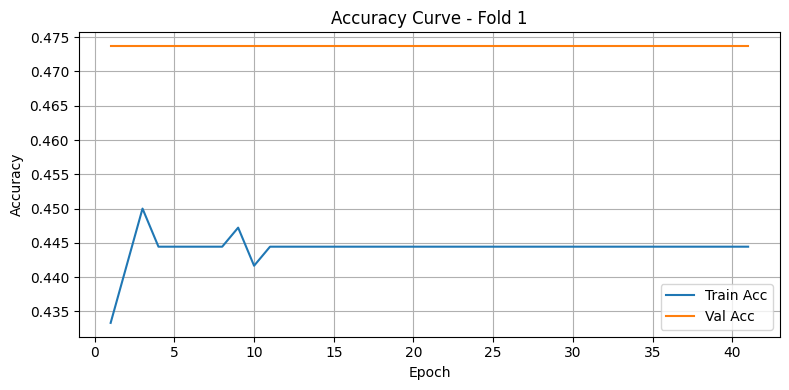

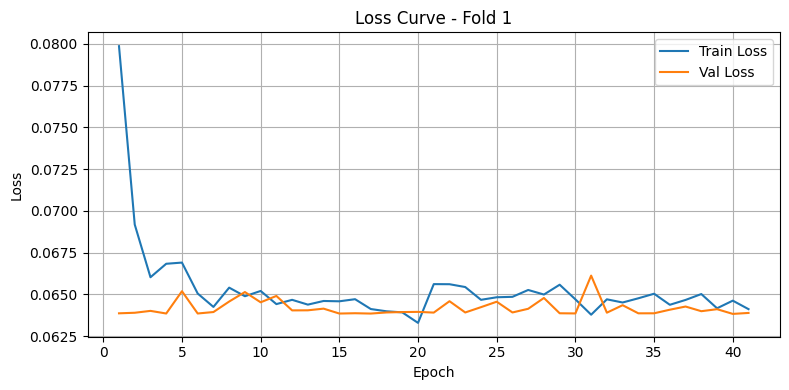


=== Fold 2/5 Dataset Info ===
Train (file-level): 73 (Healthy=33, Patient=40)
Val (file-level): 18
Pos_weight: 0.825


=== Model Info ===
Device: cpu
Total parameters: 3,929,601



[Epoch 1/200]
  Train: Loss=0.0851, Acc=0.4247
  Val:   Loss=0.0697, Acc=0.4444, F1=0.0000
  Prob range: [0.341, 0.342]
  ✓ Best acc: 0.4444



[Epoch 10/200]
  Train: Loss=0.0657, Acc=0.4521
  Val:   Loss=0.0661, Acc=0.4444, F1=0.0000
  Prob range: [0.373, 0.373]



[Epoch 20/200]
  Train: Loss=0.0609, Acc=0.6329
  Val:   Loss=0.0742, Acc=0.4444, F1=0.2857
  Prob range: [0.336, 0.572]



[Epoch 30/200]
  Train: Loss=0.0665, Acc=0.4521
  Val:   Loss=0.0654, Acc=0.4444, F1=0.0000
  Prob range: [0.418, 0.418]


KeyboardInterrupt: 

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
DATA_DIR = r"processed_lstm_inputs"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 2  # Very small batch for tiny dataset
EPOCHS = 200
LR = 5e-4  # Slightly higher to help learning
VAL_SPLIT = 0.2
LSTM_HIDDEN = 256
LSTM_LAYERS = 2
DROPOUT = 0.2
GRAD_CLIP = 1.0
NUM_WORKERS = 0
EARLY_STOP_PATIENCE = 40
NUM_FOLDS = 5  # K-fold cross-validation
AUG_FACTOR = 5  # how many augmented copies per file for training

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ---------------- Dataset ----------------
class EEGFileDataset(Dataset):
    def __init__(self, data_dir, folders=("healthy","patient"), augment=False, aug_factor=1):
        self.augment = augment
        self.aug_factor = max(1, int(aug_factor))
        self.files = []
        self.labels = []
        for label, folder in enumerate(folders):
            folder_path = os.path.join(data_dir, folder)
            if not os.path.isdir(folder_path):
                raise FileNotFoundError(f"{folder_path} not found")
            for fname in sorted(os.listdir(folder_path)):
                if fname.endswith(".npy"):
                    self.files.append(os.path.join(folder_path, fname))
                    self.labels.append(label)
        if len(self.files) == 0:
            raise RuntimeError("No .npy files found.")
        self.labels = np.array(self.labels, dtype=np.int64)

    def __len__(self):
        return len(self.files) * self.aug_factor if self.augment else len(self.files)

    def __getitem__(self, idx):
        real_idx = idx % len(self.files)
        arr = np.load(self.files[real_idx])  # expected shape (44,8,5,5,200)
        if arr.ndim != 5:
            raise ValueError(f"{self.files[real_idx]} shape {arr.shape} != (44,8,5,5,200)")
        arr = arr.astype(np.float32)
        T, C, H, W, F = arr.shape

        # Combine spatial channels then normalize per-frequency across time
        arr = arr.reshape(T, C*H*W, F)  # (T, spatial, F)
        mean = arr.mean(axis=(0, 2), keepdims=True)
        std = arr.std(axis=(0, 2), keepdims=True) + 1e-8
        arr = (arr - mean) / std
        arr = arr.mean(axis=1)  # (T, F)

        # Augmentation (applied when dataset was created with augment=True)
        if self.augment:
            # Random noise
            if np.random.rand() > 0.3:
                noise_std = np.random.uniform(0.02, 0.05)
                arr += np.random.normal(0, noise_std, arr.shape).astype(np.float32)
            # Random amplitude scaling
            if np.random.rand() > 0.3:
                scale = np.random.uniform(0.85, 1.15)
                arr *= scale
            # Time shift
            if np.random.rand() > 0.5:
                shift = np.random.randint(-5, 6)
                arr = np.roll(arr, shift, axis=0)
            # Time warping (simple resample)
            if np.random.rand() > 0.6:
                warp_factor = np.random.uniform(0.9, 1.1)
                new_len = max(1, int(T * warp_factor))
                indices = np.linspace(0, T-1, new_len)
                arr_warped = np.zeros((new_len, F), dtype=np.float32)
                for i in range(new_len):
                    idx_i = int(indices[i])
                    arr_warped[i] = arr[idx_i]
                if new_len > T:
                    arr = arr_warped[:T]
                else:
                    arr = np.pad(arr_warped, ((0, T-new_len), (0, 0)), mode='edge')
            # Frequency masking
            if np.random.rand() > 0.5:
                mask_len = np.random.randint(10, min(30, F))
                mask_start = np.random.randint(0, max(1, F - mask_len))
                arr[:, mask_start:mask_start+mask_len] *= np.random.uniform(0.1, 0.3)

        # Return (T, F) as torch tensor
        return torch.from_numpy(arr), torch.tensor(self.labels[real_idx], dtype=torch.long)

# ---------------- CNN Feature Extractor with Attention ----------------
class ChannelSpatialCNN(nn.Module):
    def __init__(self, in_features=200, hidden_channels=64, dropout=0.2):
        super().__init__()
        # We'll treat features as 1D signal per time-step and apply convs across the feature axis.
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=hidden_channels, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=hidden_channels, out_channels=hidden_channels*2, kernel_size=3, padding=1)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        # attention across channels
        self.attn_proj = nn.Sequential(
            nn.Conv1d(hidden_channels*2, hidden_channels*2, kernel_size=1),
            nn.GELU(),
            nn.Conv1d(hidden_channels*2, hidden_channels*2, kernel_size=1),
            nn.Sigmoid()
        )
        self.out_dim = hidden_channels*2

    def forward(self, x):
        # x: (batch, seq, features)
        b, s, f = x.shape
        x = x.contiguous().view(b*s, 1, f)            # (b*s, 1, f)
        x = self.conv1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.dropout(x)                          # (b*s, out_ch, f)

        att = self.attn_proj(x)                      # (b*s, out_ch, f)
        x = x * att

        # Pool across feature axis to get a vector per time-step
        x = x.mean(dim=2)                            # (b*s, out_ch)
        x = x.view(b, s, -1)                         # (b, seq, out_ch)
        return x

# ---------------- Model ----------------
class DeepLSTMModel(nn.Module):
    def __init__(self, input_size=200, hidden_size=LSTM_HIDDEN, num_layers=LSTM_LAYERS, dropout=DROPOUT):
        super().__init__()
        # CNN front-end
        self.cnn = ChannelSpatialCNN(in_features=input_size, hidden_channels=64, dropout=dropout)
        cnn_out = self.cnn.out_dim  # feature dim per time-step after cnn

        # small MLP per time-step
        self.feature_extractor = nn.Sequential(
            nn.Linear(cnn_out, cnn_out),
            nn.LayerNorm(cnn_out),
            nn.GELU(),
            nn.Dropout(dropout * 0.3)
        )

        # Bidirectional LSTM over time dimension (T)
        self.lstm = nn.LSTM(
            input_size=cnn_out,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers>1 else 0.0,
            bidirectional=True
        )

        lstm_output_size = hidden_size * 2

        # Attention (scaled dot product style) projection layers
        self.attention_query = nn.Linear(lstm_output_size, lstm_output_size)
        self.attention_key = nn.Linear(lstm_output_size, lstm_output_size)
        self.attention_value = nn.Linear(lstm_output_size, lstm_output_size)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size * 2, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(dropout * 0.8),

            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(dropout * 0.6),

            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(dropout * 0.4),

            nn.Linear(64, 1)
        )

        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif param.dim() >= 2:
                nn.init.kaiming_normal_(param)

    def forward(self, x):
        # x: (batch, seq=T, features=F)
        x = self.cnn(x)                 # (batch, seq, cnn_out)
        x = self.feature_extractor(x)   # (batch, seq, cnn_out)

        lstm_out, _ = self.lstm(x)      # (batch, seq, hidden*2)

        # Scaled dot-product attention
        Q = self.attention_query(lstm_out)
        K = self.attention_key(lstm_out)
        V = self.attention_value(lstm_out)

        d_k = lstm_out.size(-1)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (d_k ** 0.5)
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attended = torch.matmul(attention_weights, V)  # (batch, seq, hidden*2)

        # Multi-scale pooling
        max_pool = torch.max(attended, dim=1)[0]
        mean_pool = torch.mean(attended, dim=1)
        combined = torch.cat([max_pool, mean_pool], dim=1)

        logits = self.classifier(combined).squeeze(1)
        return logits

# ---------------- Mixup augmentation ----------------
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ---------------- Loss ----------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        # logits: (batch,)
        targets = targets.float()
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, pos_weight=self.pos_weight, reduction='none'
        )
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_weight = (1 - pt) ** self.gamma
        alpha_weight = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        loss = alpha_weight * focal_weight * bce_loss
        return loss.mean()

# ---------------- Helpers ----------------
def prepare_loaders_kfold(data_dir, fold_idx=0, aug_factor=AUG_FACTOR):
    full_ds = EEGFileDataset(data_dir, augment=False, aug_factor=1)
    n_files = len(full_ds)
    indices = np.arange(n_files)
    labels = np.array([full_ds[i][1].item() for i in range(n_files)])

    skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
    splits = list(skf.split(indices, labels))
    train_files_idx, val_files_idx = splits[fold_idx]

    # Create augmented training dataset (we will select indices so each train file appears aug_factor times)
    train_ds_aug = EEGFileDataset(data_dir, augment=True, aug_factor=aug_factor)
    # build indices into the augmented dataset such that each file in train_files_idx is repeated aug_factor times
    augmented_indices = []
    for fidx in train_files_idx:
        for k in range(aug_factor):
            augmented_indices.append(fidx + k * n_files)

    train_ds = torch.utils.data.Subset(train_ds_aug, augmented_indices)
    val_ds = torch.utils.data.Subset(full_ds, val_files_idx)

    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, 
        num_workers=NUM_WORKERS, drop_last=False
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
    )

    train_labels = labels[train_files_idx]
    neg = int((train_labels == 0).sum())
    pos = int((train_labels == 1).sum())
    pos_weight = torch.tensor([neg / (pos + 1e-12)], dtype=torch.float32).to(DEVICE)

    print(f"\n=== Fold {fold_idx+1}/{NUM_FOLDS} Dataset Info ===")
    print(f"Train (file-level): {len(train_files_idx)} (Healthy={neg}, Patient={pos})")
    print(f"Val (file-level): {len(val_files_idx)}")
    print(f"Pos_weight: {pos_weight.item():.3f}\n")

    return train_loader, val_loader, pos_weight

# ---------------- Train & Evaluate ----------------
def train_fold(fold_idx=0):
    train_loader, val_loader, pos_weight = prepare_loaders_kfold(DATA_DIR, fold_idx)
    model = DeepLSTMModel().to(DEVICE)

    print(f"\n=== Model Info ===")
    print(f"Device: {DEVICE}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    criterion = FocalLoss(alpha=0.25, gamma=2.0, pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=5e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=20, T_mult=2, eta_min=1e-7
    )

    best_val_acc = 0.0
    patience_counter = 0

    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

    for epoch in range(1, EPOCHS+1):
        # Training
        model.train()
        train_losses = []
        train_preds, train_trues = [], []

        for X, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False):
            X = X.to(DEVICE)
            y = y.to(DEVICE).float()

            # Apply mixup sometimes
            if np.random.rand() > 0.5 and X.size(0) > 1:
                X_mixed, y_a, y_b, lam = mixup_data(X, y, alpha=0.2)
                optimizer.zero_grad()
                logits = model(X_mixed)
                loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
            else:
                optimizer.zero_grad()
                logits = model(X)
                loss = criterion(logits, y)

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            train_losses.append(loss.item())
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            train_preds.extend((probs >= 0.5).astype(int).tolist())
            train_trues.extend(y.cpu().numpy().astype(int).tolist())

        scheduler.step()

        # Validation
        model.eval()
        val_losses = []
        val_preds, val_trues = [], []
        val_probs_all = []

        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv = Xv.to(DEVICE)
                yv = yv.to(DEVICE).float()
                logits = model(Xv)
                loss = criterion(logits, yv)
                val_losses.append(loss.item())
                probs = torch.sigmoid(logits).cpu().numpy()
                val_probs_all.extend(probs.tolist())
                val_preds.extend((probs >= 0.5).astype(int).tolist())
                val_trues.extend(yv.cpu().numpy().astype(int).tolist())

        avg_train = float(np.mean(train_losses)) if len(train_losses)>0 else 0.0
        avg_val = float(np.mean(val_losses)) if len(val_losses)>0 else 0.0
        train_acc = accuracy_score(train_trues, train_preds) if len(train_trues)>0 else 0.0
        val_acc = accuracy_score(val_trues, val_preds) if len(val_trues)>0 else 0.0
        val_f1 = f1_score(val_trues, val_preds, zero_division=0)

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(avg_train)
        history["val_loss"].append(avg_val)

        if epoch % 10 == 0 or val_acc > best_val_acc:
            print(f"\n[Epoch {epoch}/{EPOCHS}]")
            print(f"  Train: Loss={avg_train:.4f}, Acc={train_acc:.4f}")
            print(f"  Val:   Loss={avg_val:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")
            if len(val_probs_all)>0:
                print(f"  Prob range: [{min(val_probs_all):.3f}, {max(val_probs_all):.3f}]")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_acc': val_acc,
            }, f"best_model_fold{fold_idx}.pth")
            print(f"  ✓ Best acc: {best_val_acc:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping at epoch {epoch}")
            break

    # Load best and evaluate
    checkpoint = torch.load(f"best_model_fold{fold_idx}.pth", map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])

    all_preds, all_trues = [], []
    model.eval()
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(DEVICE)
            logits = model(Xv)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend((probs >= 0.5).astype(int).tolist())
            all_trues.extend(yv.cpu().numpy().astype(int).tolist())

    acc = accuracy_score(all_trues, all_preds) if len(all_trues)>0 else 0.0
    f1 = f1_score(all_trues, all_preds, zero_division=0)
    cm = confusion_matrix(all_trues, all_preds) if len(all_trues)>0 else np.zeros((2,2), dtype=int)

    print(f"\n=== Fold {fold_idx+1} Final Results ===")
    print(f"Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    print(f"F1-score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    return acc, f1, cm, history

# ---------------- Plotting ----------------
def plot_learning_curves(history, fold):
    epochs = range(1, len(history["train_acc"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title(f"Accuracy Curve - Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"Loss Curve - Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# ---------------- Train & CV ----------------
def train_and_evaluate():
    print("="*60)
    print("STARTING K-FOLD CROSS-VALIDATION")
    print("="*60)
    all_accs = []
    all_f1s = []

    for fold in range(NUM_FOLDS):
        acc, f1, cm, hist = train_fold(fold)
        all_accs.append(acc)
        all_f1s.append(f1)
        plot_learning_curves(hist, fold+1)

    print("\n" + "="*60)
    print("CROSS-VALIDATION RESULTS")
    print("="*60)
    print(f"Mean Accuracy: {np.mean(all_accs):.4f} ± {np.std(all_accs):.4f}")
    print(f"Mean F1-score: {np.mean(all_f1s):.4f} ± {np.std(all_f1s):.4f}")
    print(f"Individual fold accuracies: {[f'{a:.4f}' for a in all_accs]}")

    if np.mean(all_accs) >= 0.90:
        print(f"\n🎉 SUCCESS! Achieved {np.mean(all_accs)*100:.2f}% average accuracy!")
    else:
        print(f"\n⚠  Current: {np.mean(all_accs)*100:.2f}% - Try adjusting hyperparameters")

if __name__ == "__main__":
    train_and_evaluate()
